In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
CICIDS_data = pd.read_csv('MachineLearningCVE/Wednesday-workingHours.pcap_ISCX.csv')

In [3]:
CICIDS_data.shape

(692703, 79)

In [4]:
CICIDS_data.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,80,38308,1,1,6,6,6,6,6.000000,0.000000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,389,479,11,5,172,326,79,0,15.636364,31.449238,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,88,1095,10,6,3150,3150,1575,0,315.000000,632.561635,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,389,15206,17,12,3452,6660,1313,0,203.058823,425.778474,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,88,1092,9,6,3150,3152,1575,0,350.000000,694.509719,...,32,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [5]:
'''cleaning the columns names'''
CICIDS_data.columns = [col.strip() for col in CICIDS_data.columns]

In [6]:
'''droping all zero columns'''
CICIDS_data.drop(CICIDS_data.columns[CICIDS_data.eq(0).all()], axis=1, inplace=True)

In [7]:
'''droping duplicated columns'''
def find_duplicated_columns(df):
    grouped_columns = []
    seen_columns = set()
    for col in df.columns:
        if col not in seen_columns:
            duplicates = [col] + [c for c in df.columns if c != col and df[col].equals(df[c])]
            if len(duplicates)>1:
                grouped_columns.extend(duplicates[1:])
            seen_columns.update(duplicates)
    return grouped_columns

CICIDS_data.drop(find_duplicated_columns(CICIDS_data), axis=1, inplace=True)

In [8]:
CICIDS_data.columns

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count'

In [9]:
CICIDS_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 692703 entries, 0 to 692702
Data columns (total 63 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Destination Port             692703 non-null  int64  
 1   Flow Duration                692703 non-null  int64  
 2   Total Fwd Packets            692703 non-null  int64  
 3   Total Backward Packets       692703 non-null  int64  
 4   Total Length of Fwd Packets  692703 non-null  int64  
 5   Total Length of Bwd Packets  692703 non-null  int64  
 6   Fwd Packet Length Max        692703 non-null  int64  
 7   Fwd Packet Length Min        692703 non-null  int64  
 8   Fwd Packet Length Mean       692703 non-null  float64
 9   Fwd Packet Length Std        692703 non-null  float64
 10  Bwd Packet Length Max        692703 non-null  int64  
 11  Bwd Packet Length Min        692703 non-null  int64  
 12  Bwd Packet Length Mean       692703 non-null  float64
 13 

In [10]:
CICIDS_data['Label'].value_counts()

BENIGN              440031
DoS Hulk            231073
DoS GoldenEye        10293
DoS slowloris         5796
DoS Slowhttptest      5499
Heartbleed              11
Name: Label, dtype: int64

In [11]:
CICIDS_data['Destination Port'].nunique()

30094

In [12]:
CICIDS_data['Destination Port'].value_counts()[:30]

80       301422
53       195531
443      100229
123        4293
22         2169
137        1480
389        1136
21         1112
88          932
465         691
139         578
3268        476
0           330
138         326
445         259
5353        148
135         141
49666       127
49671        59
5355         51
8080         27
58122        26
444          18
53236        14
51994        14
7973         14
42           13
8612         13
36522        13
53498        13
Name: Destination Port, dtype: int64

### Flow-based Features

In [13]:
flow_columns = ['Flow Duration', 'Flow Bytes/s', 'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 
                'Flow IAT Max', 'Flow IAT Min']

In [14]:
cicids_flow_data = CICIDS_data[flow_columns]

In [15]:
cicids_flow_data.isna().sum()

Flow Duration        0
Flow Bytes/s      1008
Flow Packets/s       0
Flow IAT Mean        0
Flow IAT Std         0
Flow IAT Max         0
Flow IAT Min         0
dtype: int64

In [16]:
cicids_flow_data.describe()

,Flow Duration,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min
count,6.927030e+05,6.916950e+05,6.927030e+05,6.927030e+05,6.927030e+05,6.927030e+05,6.927030e+05
mean,2.800168e+07,inf,inf,2.502809e+06,6.844318e+06,2.289307e+07,2.224592e+05
std,4.276680e+07,NaN,NaN,5.595945e+06,1.175401e+07,3.839395e+07,3.673248e+06
min,-1.000000e+00,-1.200000e+07,-2.000000e+06,-1.000000e+00,0.000000e+00,-1.000000e+00,-1.400000e+01
25%,2.010000e+02,1.028251e+02,2.857569e-01,7.900000e+01,0.000000e+00,1.730000e+02,1.000000e+00
50%,6.143700e+04,5.190026e+02,6.338341e+01,2.509567e+04,1.509993e+04,5.451000e+04,3.000000e+00
75%,8.302437e+07,1.890071e+04,1.834862e+04,3.706981e+06,4.973849e+06,2.500000e+07,4.900000e+01
max,1.200000e+08,inf,inf,1.200000e+08,8.480000e+07,1.200000e+08,1.200000e+08


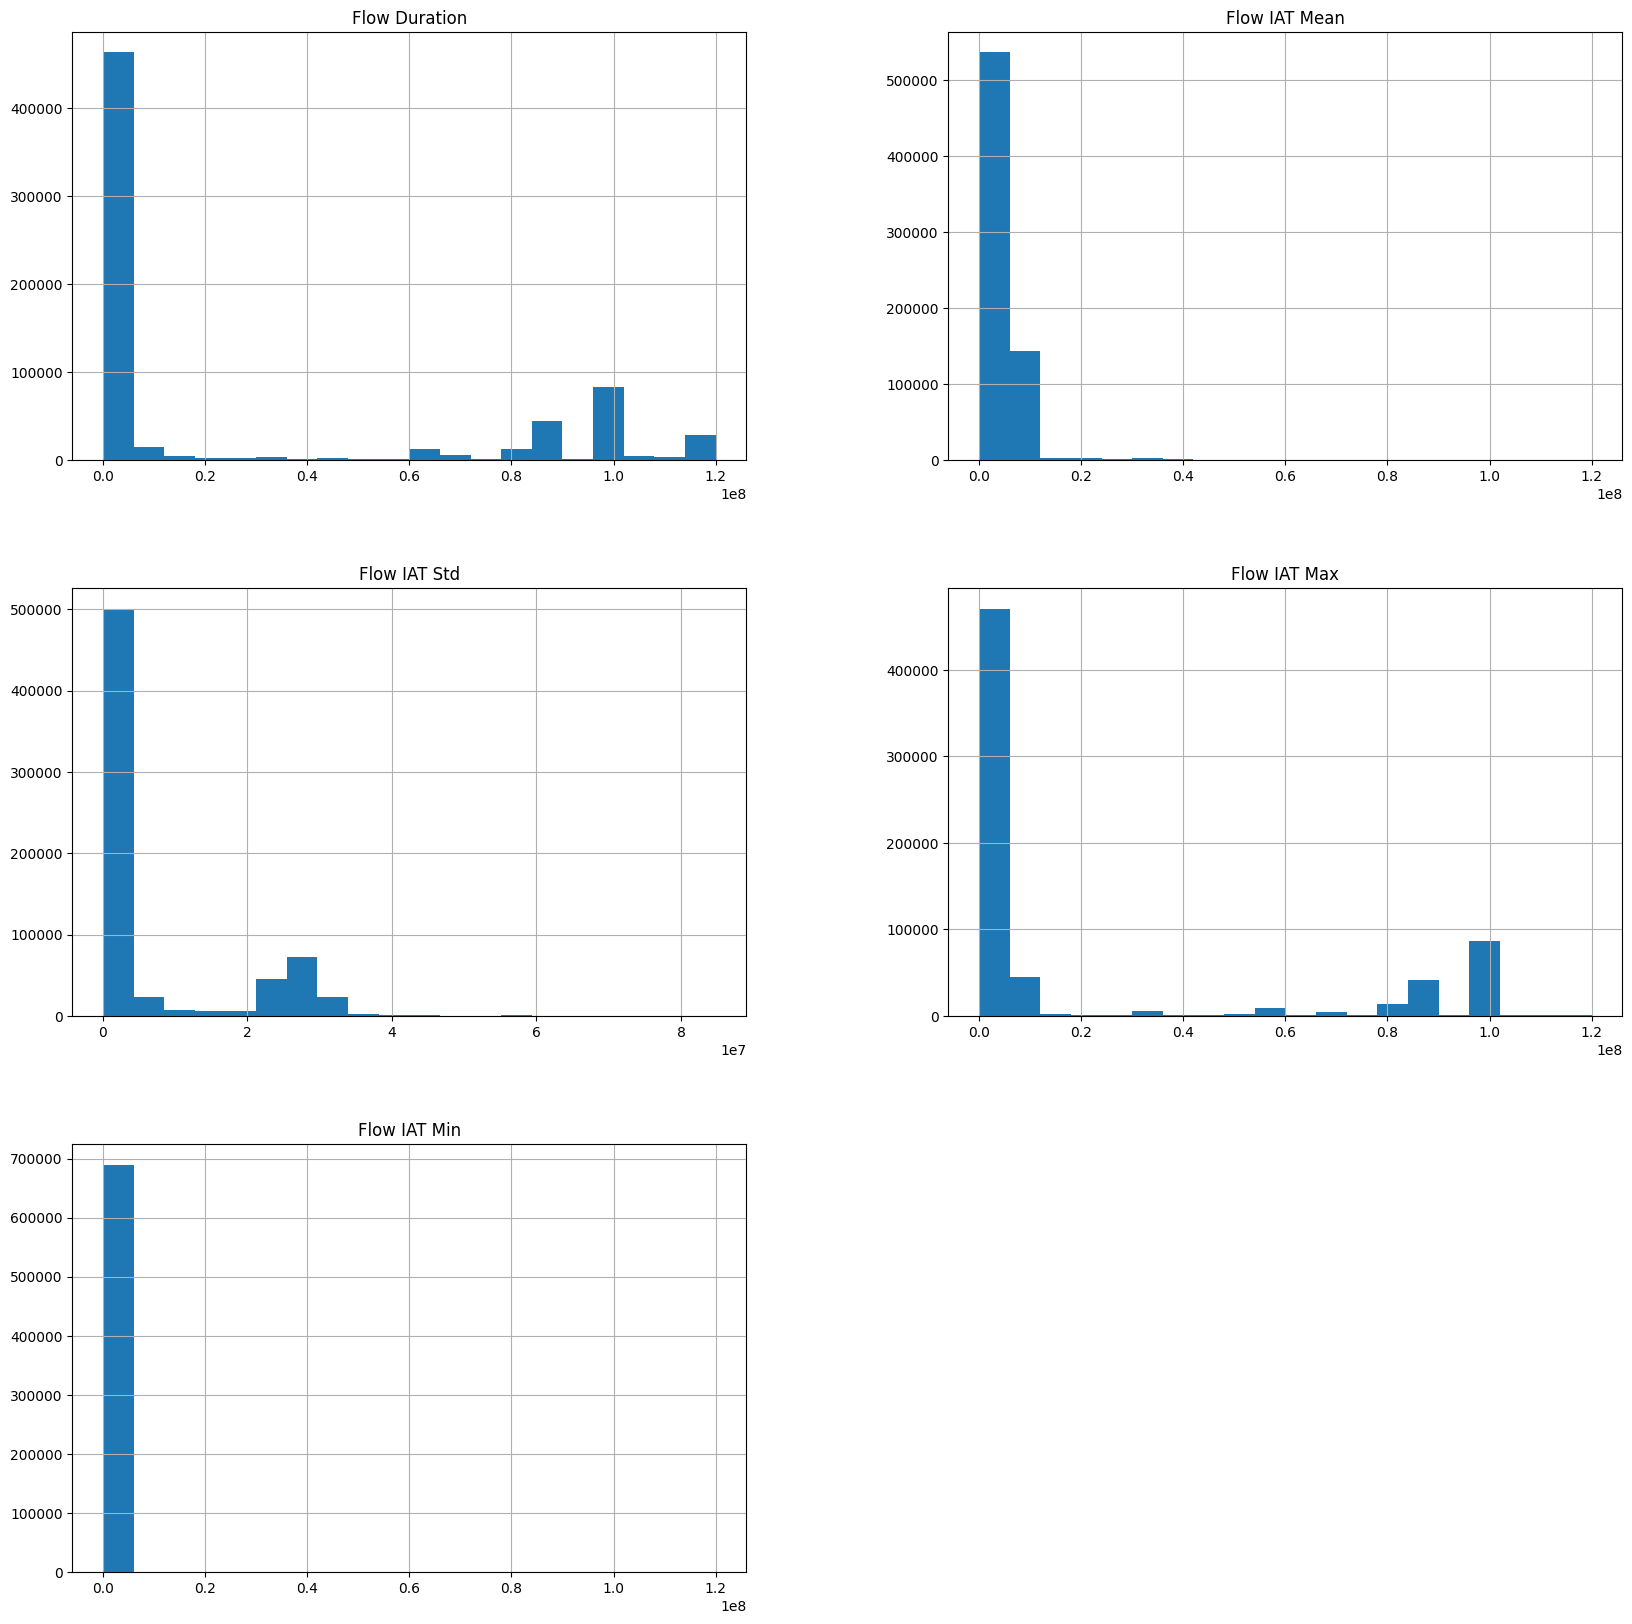

In [17]:
cicids_flow_data.drop(['Flow Bytes/s','Flow Packets/s'], axis=1).hist(figsize=(20, 20), bins=20)
plt.show()

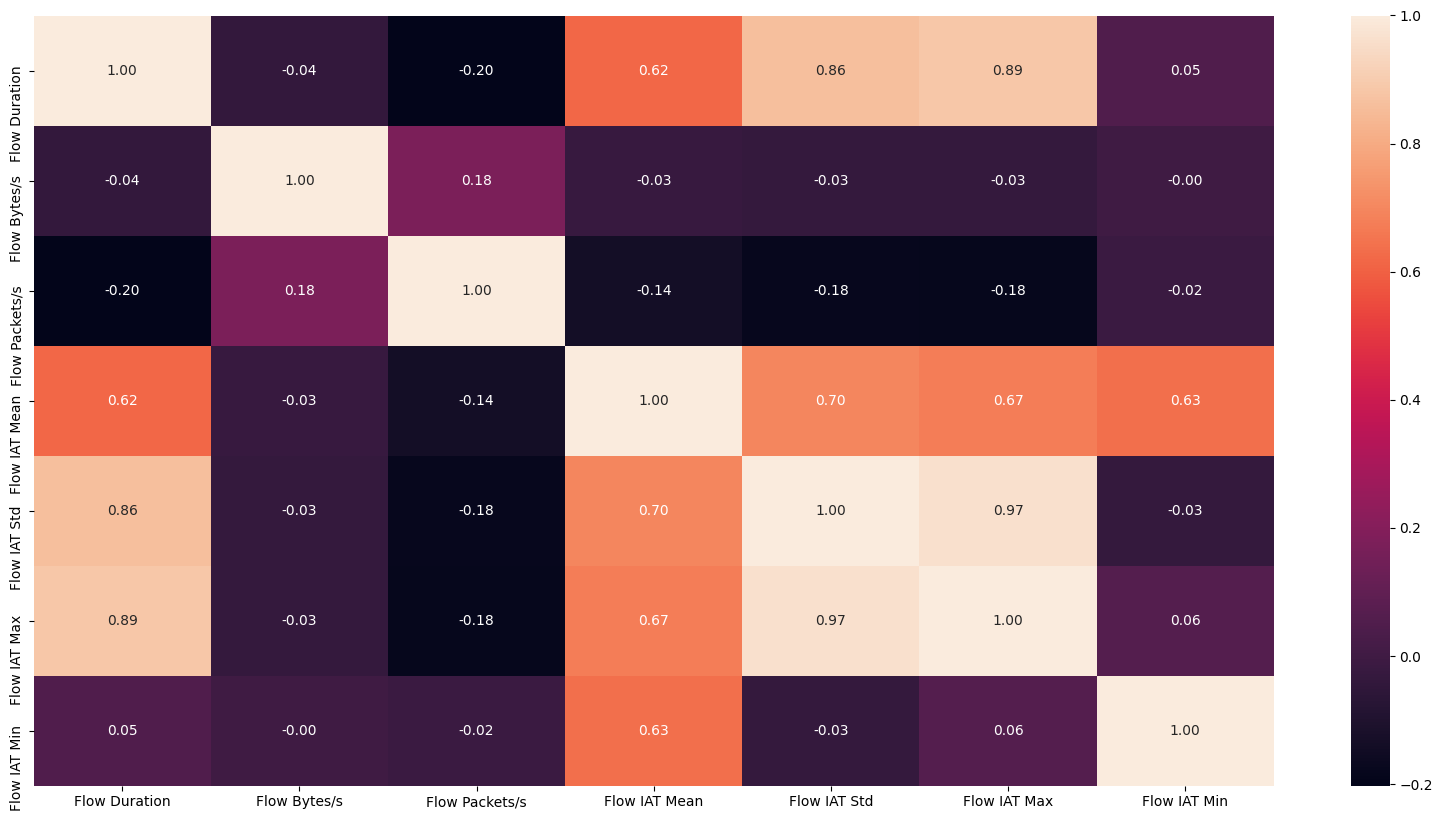

In [18]:
plt.figure(figsize=(20, 10))
corr = cicids_flow_data.corr()
sns.heatmap(corr, annot=True, fmt=".2f")
plt.show()

### Basic Features

In [19]:
basic_columns = ['Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 
                 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min',
                 'Fwd Packet Length Mean', 'Fwd Packet Length Std', 'Bwd Packet Length Max', 
                 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Bwd Packet Length Std']

In [20]:
CICIDS_data[basic_columns].describe()

,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std
count,692703.000000,692703.000000,6.927030e+05,6.927030e+05,692703.000000,692703.000000,692703.000000,692703.000000,692703.000000,692703.000000,692703.000000,692703.000000
mean,9.556261,10.214079,5.550930e+02,1.699644e+04,233.593936,15.022183,60.555440,82.895863,1661.546313,33.832924,551.940841,658.636320
std,747.197814,984.204633,6.163663e+03,2.241175e+06,603.751856,51.068835,157.643794,226.126084,2613.924428,64.586498,797.449564,1098.043102
min,1.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,1.200000e+01,0.000000e+00,6.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,2.000000,8.200000e+01,1.880000e+02,46.000000,0.000000,41.000000,0.000000,113.000000,0.000000,102.000000,0.000000
75%,7.000000,6.000000,3.650000e+02,1.159500e+04,341.000000,32.000000,56.666667,128.916917,2896.000000,58.000000,917.600000,927.603358
max,203943.000000,272353.000000,1.224076e+06,6.270000e+08,24820.000000,2065.000000,4640.757576,6429.190773,19530.000000,1983.000000,4370.686524,6715.738331


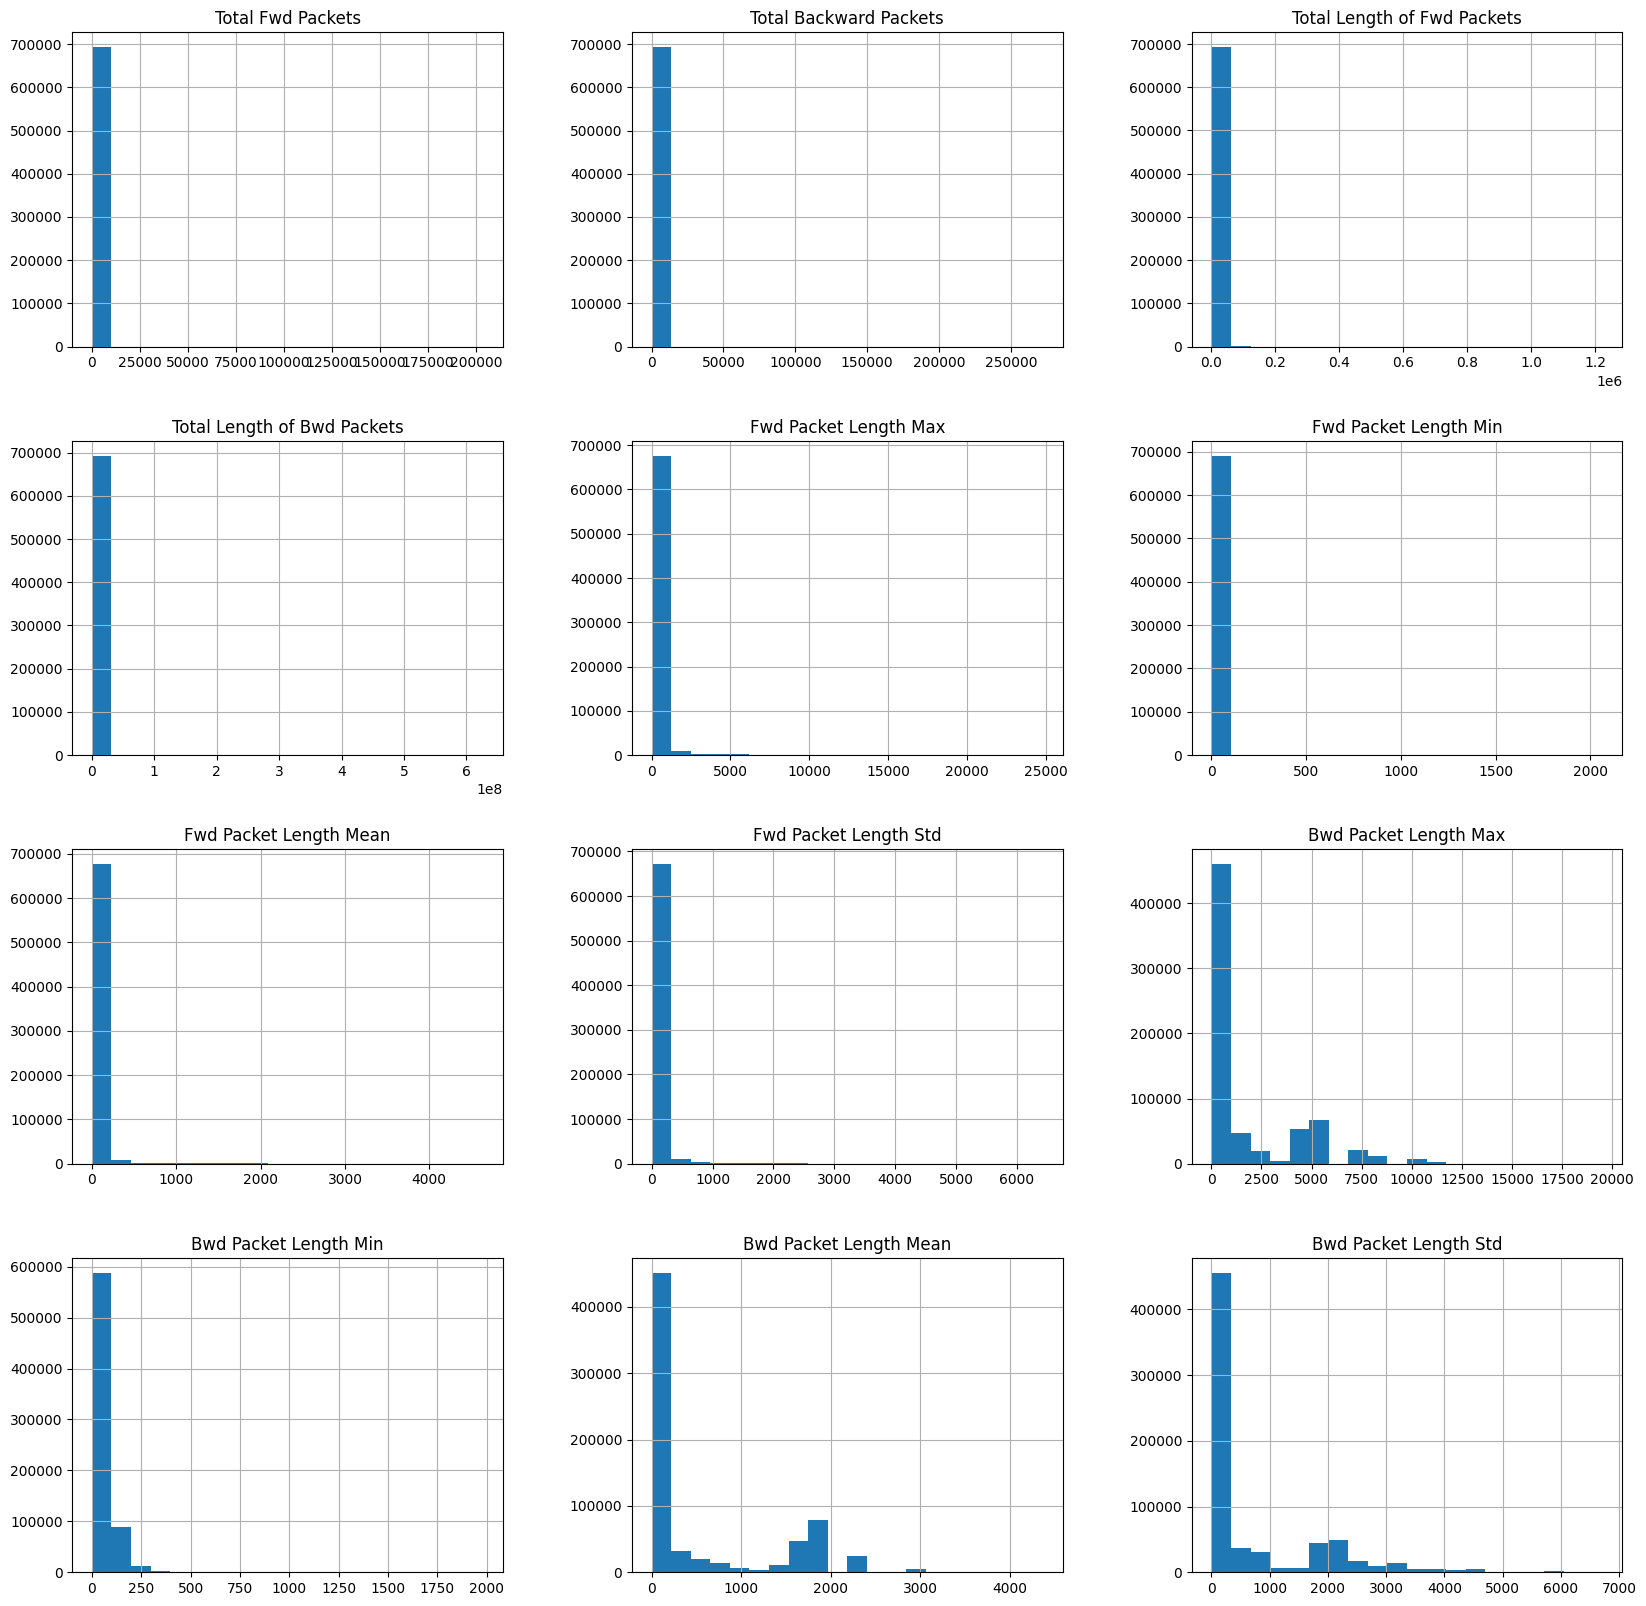

In [21]:
CICIDS_data[basic_columns].hist(figsize=(20, 20), bins=20)
plt.show()

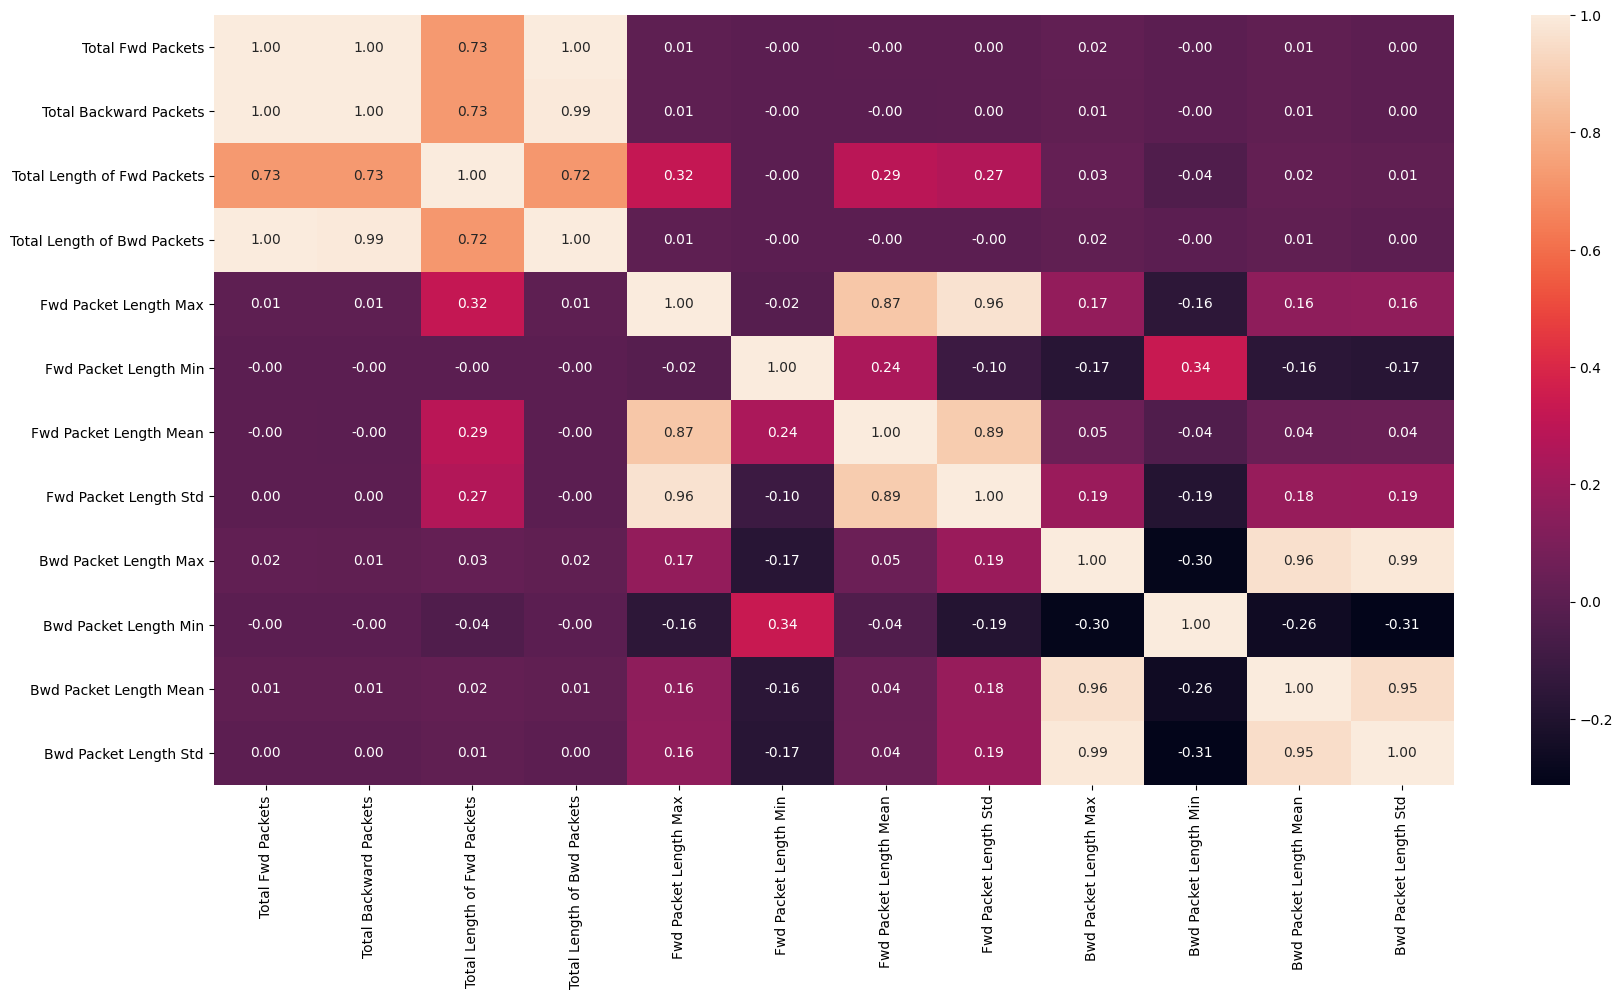

In [22]:
plt.figure(figsize=(20, 10))
corr = CICIDS_data[basic_columns].corr()
sns.heatmap(corr, annot=True, fmt=".2f")
plt.show()

### Timing-Base Featurs

In [23]:
timing_columns = ['Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min']

In [24]:
CICIDS_data[timing_columns].describe()

,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min
count,6.927030e+05,6.927030e+05,6.927030e+05,6.927030e+05,6.927030e+05,6.927030e+05,6.927030e+05,6.927030e+05,6.927030e+05,6.927030e+05
mean,2.774476e+07,5.069287e+06,9.016685e+06,2.279837e+07,1.030778e+06,1.386407e+07,2.647068e+06,3.522882e+06,9.305284e+06,9.268549e+05
std,4.277094e+07,1.103613e+07,1.600574e+07,3.843629e+07,8.866760e+06,3.335293e+07,9.593760e+06,1.073828e+07,2.616633e+07,8.107914e+06
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.000000e+00,3.000000e+00,0.000000e+00,3.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,1.002000e+03,9.670000e+02,0.000000e+00,9.960000e+02,3.000000e+00,4.000000e+00,4.000000e+00,0.000000e+00,4.000000e+00,3.000000e+00
75%,8.290000e+07,6.997846e+06,5.009074e+06,2.370000e+07,4.900000e+01,1.575400e+05,3.609575e+04,5.970159e+04,1.382425e+05,4.800000e+01
max,1.200000e+08,1.200000e+08,8.370000e+07,1.200000e+08,1.200000e+08,1.200000e+08,1.200000e+08,8.290000e+07,1.200000e+08,1.200000e+08


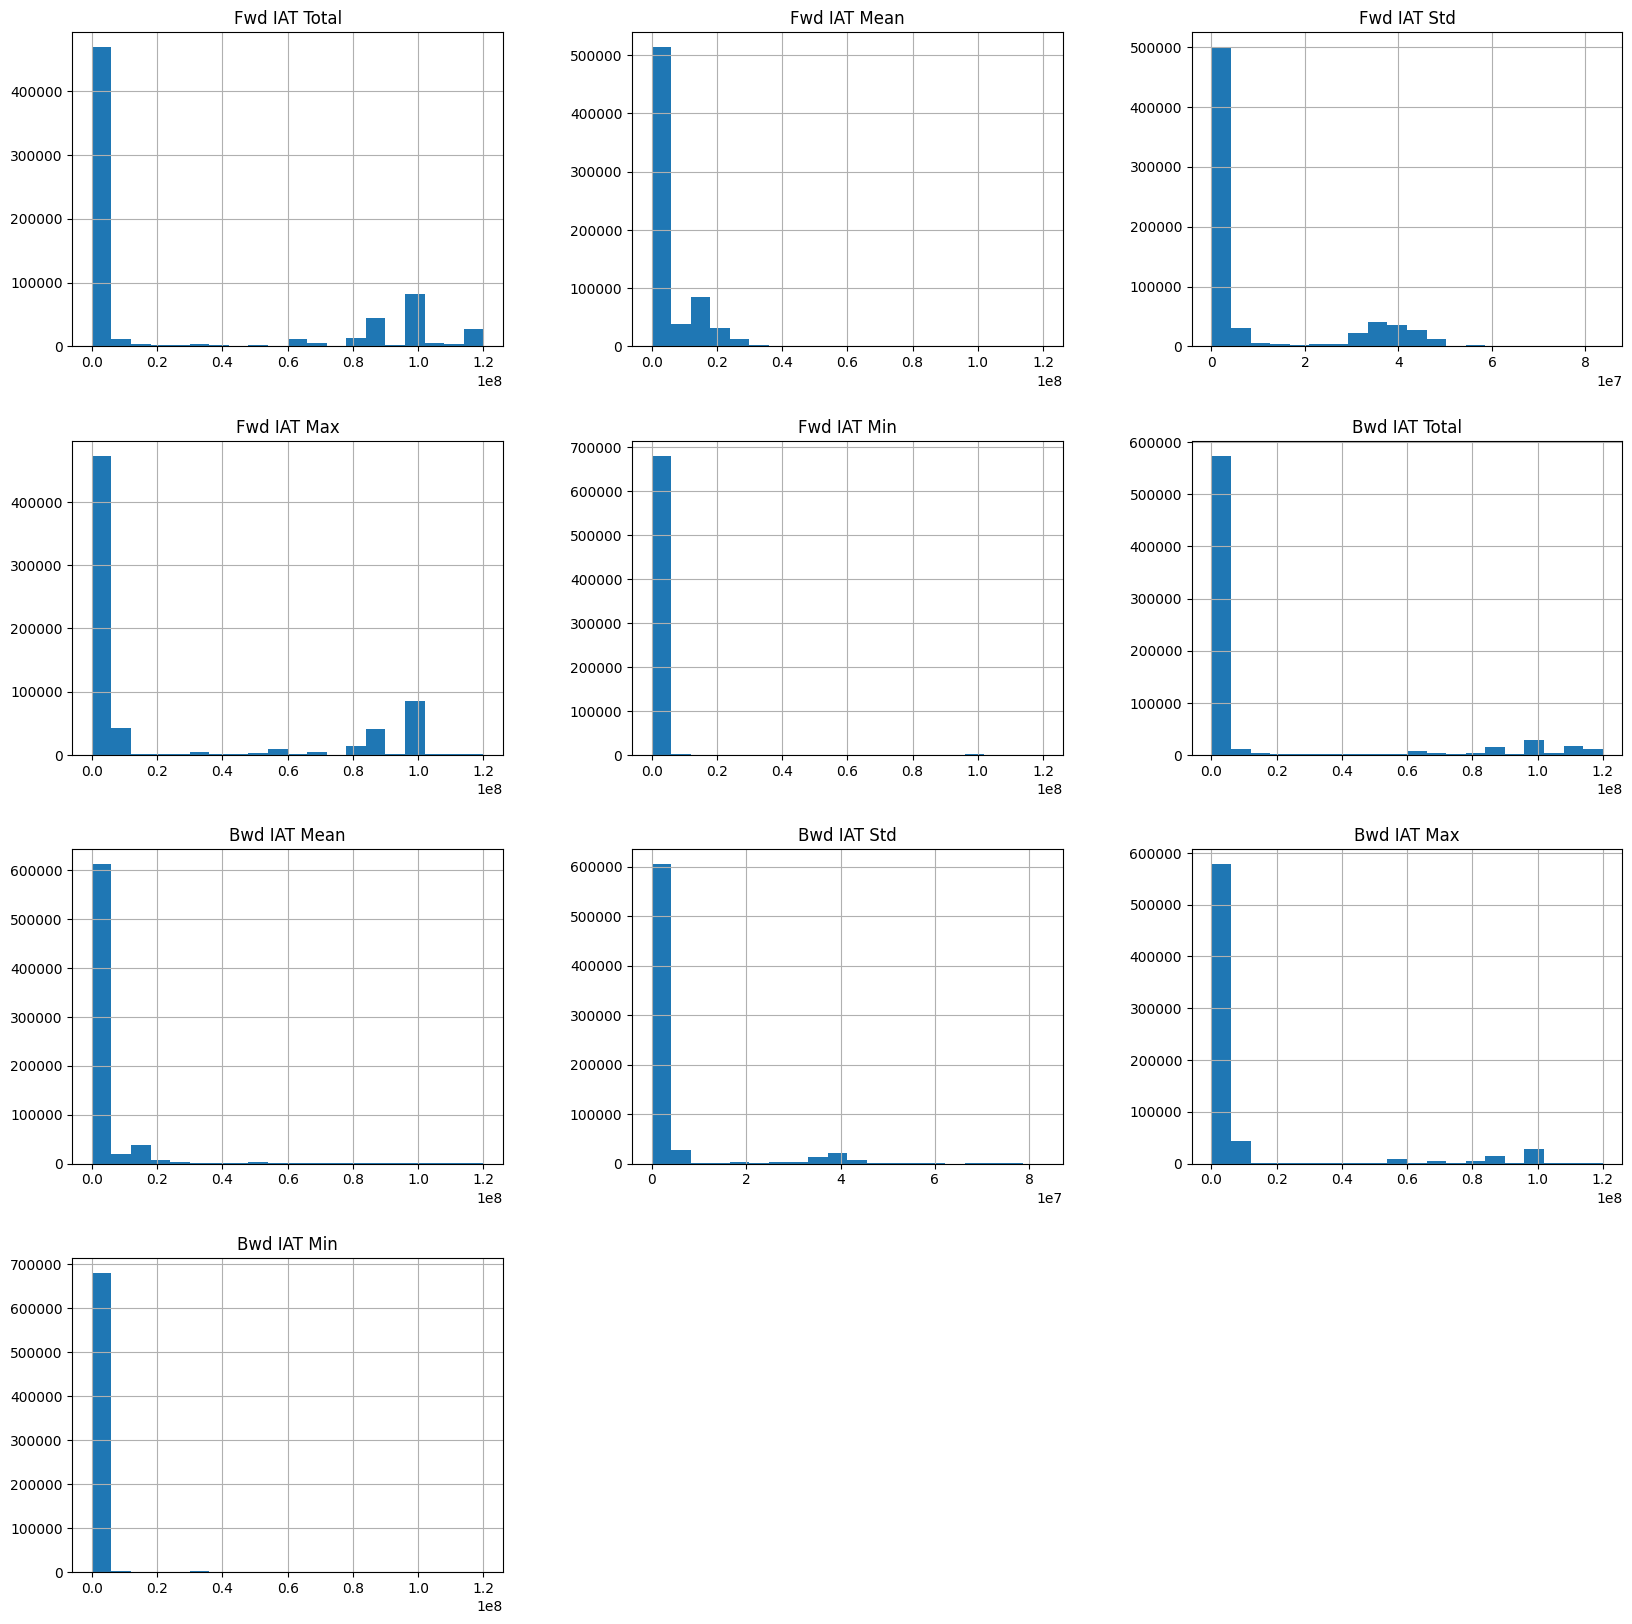

In [25]:
CICIDS_data[timing_columns].hist(figsize=(20, 20), bins=20)
plt.show()

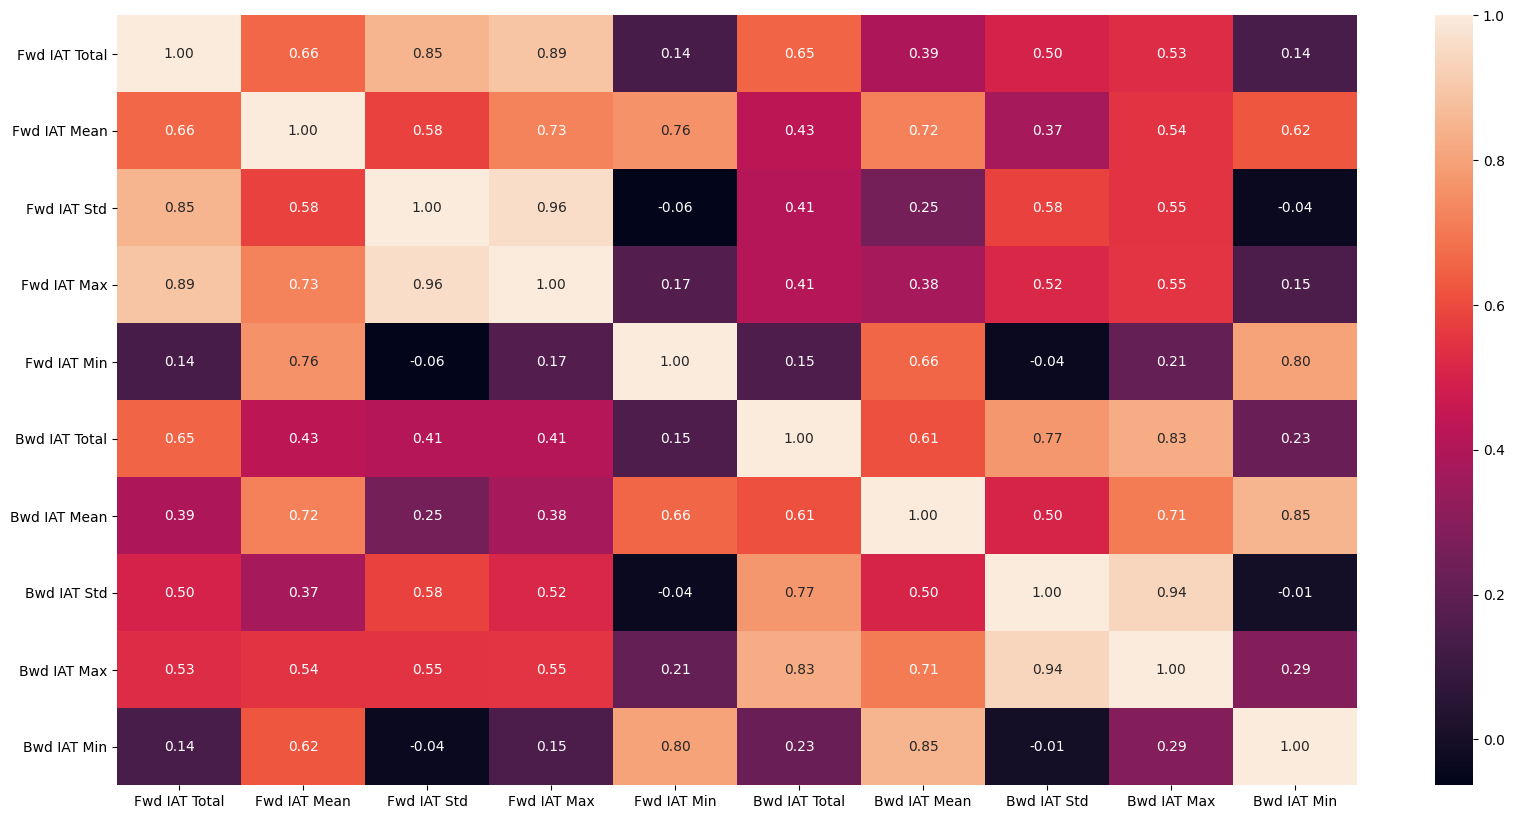

In [26]:
plt.figure(figsize=(20, 10))
corr = CICIDS_data[timing_columns].corr()
sns.heatmap(corr, annot=True, fmt=".2f")
plt.show()

### Content-Base Features 

In [27]:
content_columns = ['Fwd PSH Flags']

In [28]:
CICIDS_data[content_columns].describe()

,Fwd PSH Flags
count,692703.000000
mean,0.042201
std,0.201048
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


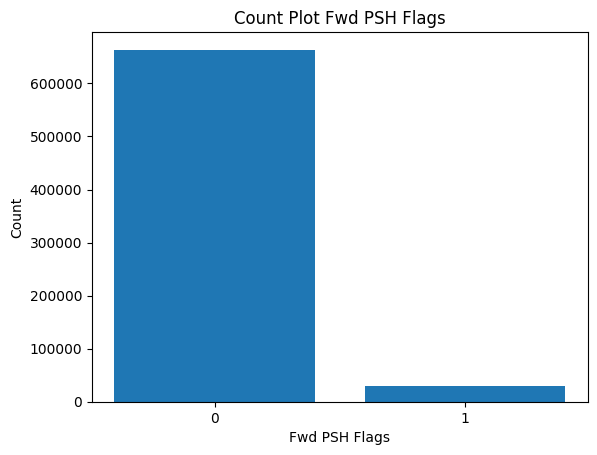

In [29]:
Fwd_PSH_Flags = CICIDS_data['Fwd PSH Flags'].value_counts()
plt.bar(Fwd_PSH_Flags.index, Fwd_PSH_Flags.values)
plt.title('Count Plot Fwd PSH Flags')
plt.xlabel('Fwd PSH Flags')
plt.ylabel('Count')
plt.xticks([0, 1], ['0', '1'])
plt.show()

### Header-Base Featurs

In [30]:
header_columns = ['Fwd Header Length', 'Bwd Header Length']

In [31]:
CICIDS_data[header_columns].describe()

,Fwd Header Length,Bwd Header Length
count,6.927030e+05,6.927030e+05
mean,2.420580e+02,2.492460e+02
std,1.564277e+04,1.968957e+04
min,-1.100000e+01,0.000000e+00
25%,4.000000e+01,2.000000e+01
50%,6.400000e+01,6.400000e+01
75%,2.000000e+02,2.000000e+02
max,4.290372e+06,5.447060e+06


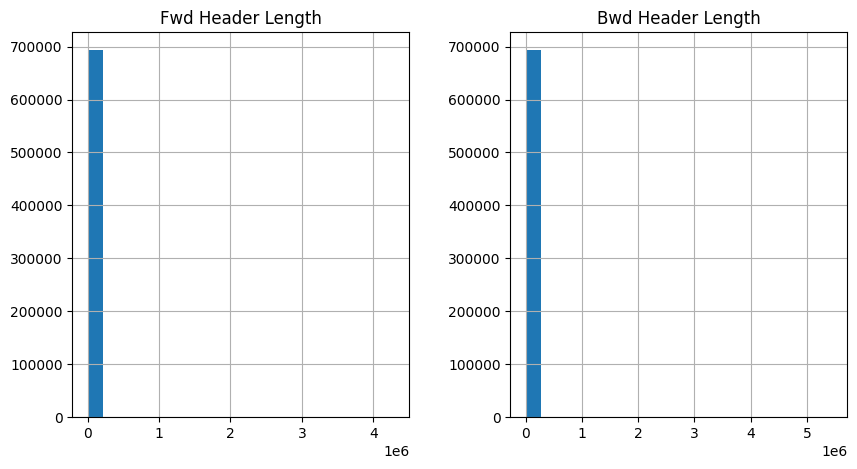

In [32]:
CICIDS_data[header_columns].hist(figsize=(10, 5), bins=20)
plt.show()

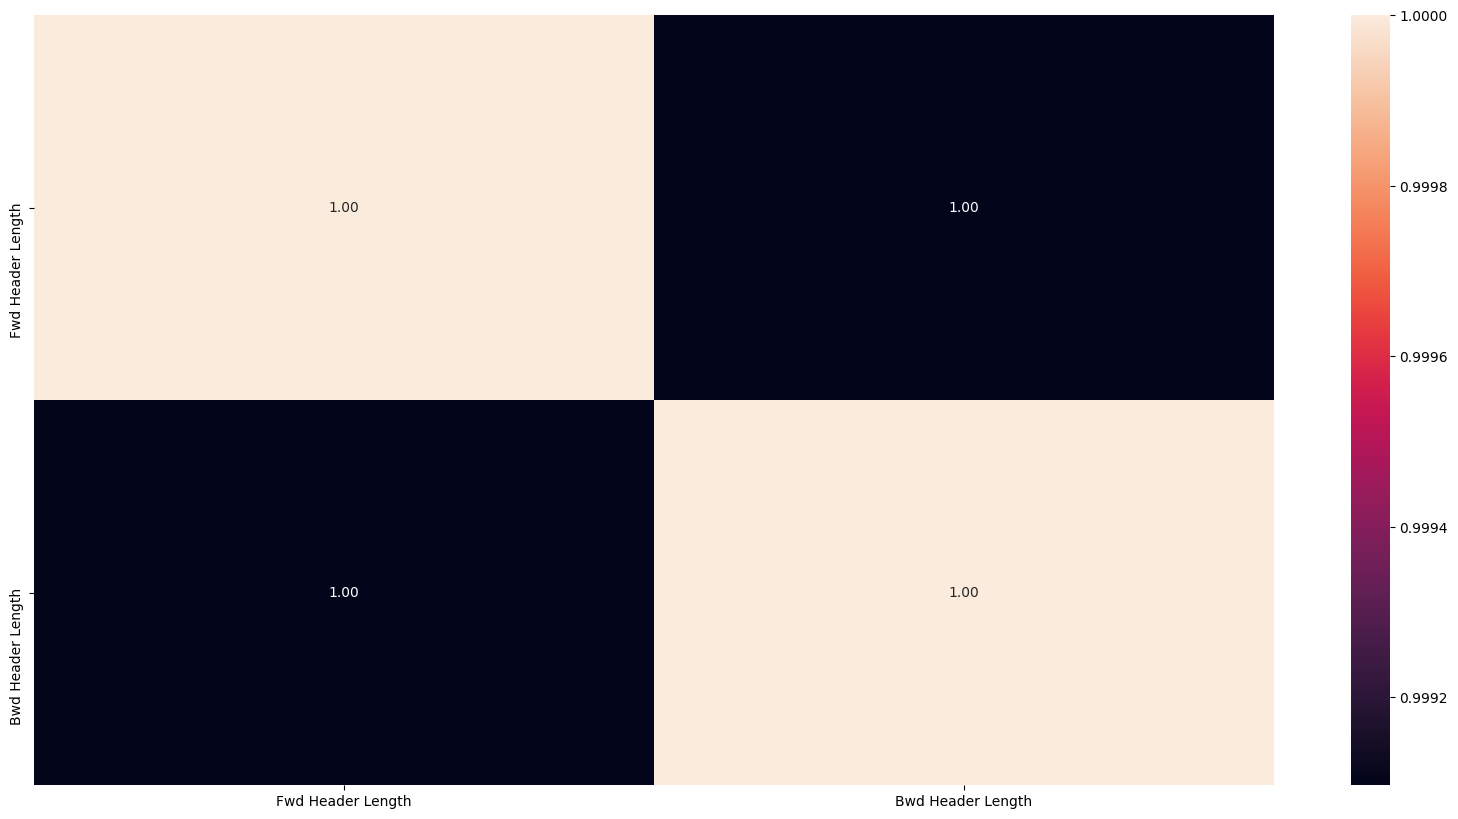

In [33]:
plt.figure(figsize=(20, 10))
corr = CICIDS_data[header_columns].corr()
sns.heatmap(corr, annot=True, fmt=".2f")
plt.show()

### Packet-Base Features

In [34]:
packet_columns = ['Fwd Packets/s', 'Bwd Packets/s', 'Min Packet Length', 'Max Packet Length', 
                  'Packet Length Mean', 'Packet Length Std', 'Packet Length Variance']

In [35]:
CICIDS_data[packet_columns].describe()

,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance
count,6.927030e+05,6.927030e+05,692703.000000,692703.000000,692703.000000,692703.000000,6.927030e+05
mean,9.545305e+04,4.052544e+03,13.723771,1725.129073,278.246605,523.265612,8.876018e+05
std,3.198607e+05,3.091927e+04,27.521716,2634.372188,369.130494,783.442461,1.748895e+06
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,1.492719e-01,5.941689e-02,0.000000,6.000000,6.000000,0.000000,0.000000e+00
50%,3.172891e+01,3.602232e-01,0.000000,123.000000,70.454545,43.323259,1.876905e+03
75%,9.708738e+03,6.104633e+01,32.000000,3072.000000,663.833333,984.512580,9.692650e+05
max,3.000000e+06,2.000000e+06,1448.000000,24820.000000,2279.754386,4364.022571,1.900000e+07


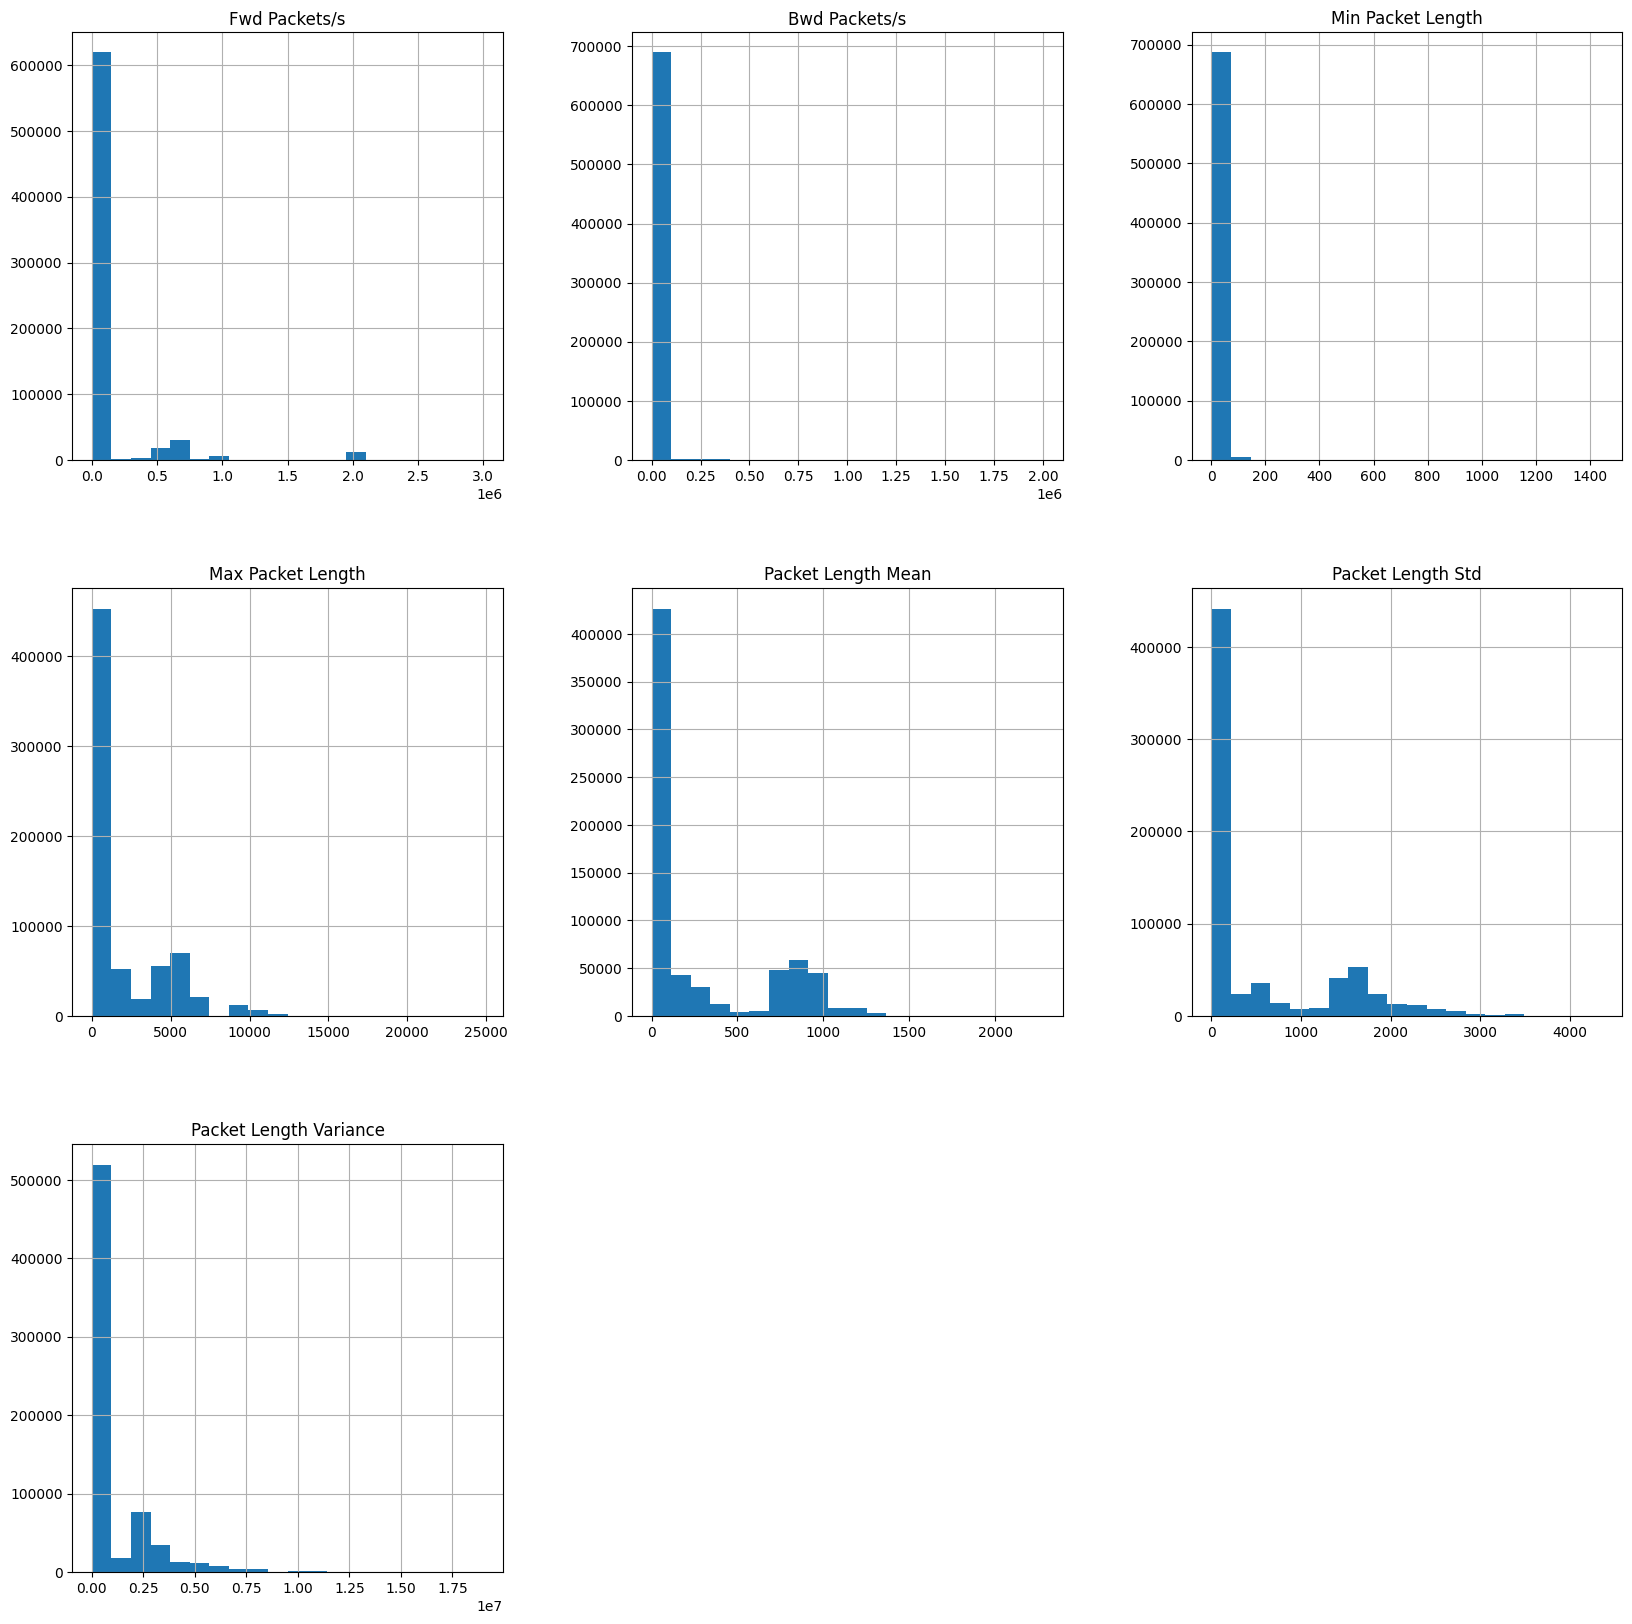

In [36]:
CICIDS_data[packet_columns].hist(figsize=(20, 20), bins=20)
plt.show()

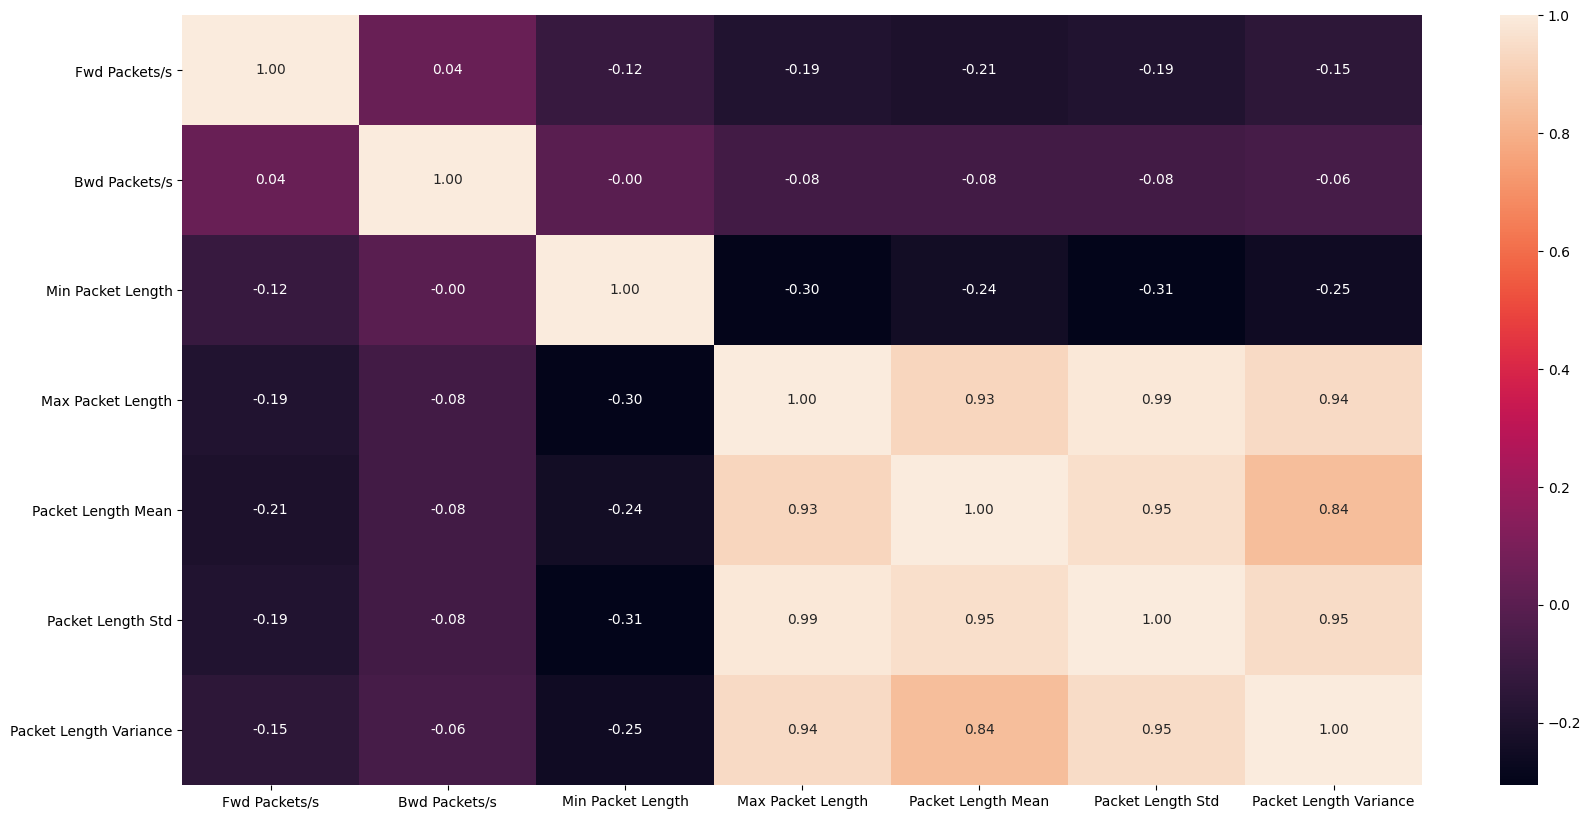

In [37]:
plt.figure(figsize=(20, 10))
corr = CICIDS_data[packet_columns].corr()
sns.heatmap(corr, annot=True, fmt=".2f")
plt.show()

### Flag-Base Features

In [38]:
flag_columns = ['FIN Flag Count', 'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count',
                'URG Flag Count',  'ECE Flag Count']

In [39]:
CICIDS_data[flag_columns].describe()

,FIN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,ECE Flag Count
count,692703.000000,692703.000000,692703.000000,692703.000000,692703.000000,692703.000000
mean,0.097301,0.000338,0.193693,0.418049,0.066372,0.000339
std,0.296368,0.018376,0.395192,0.493239,0.248931,0.018416
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


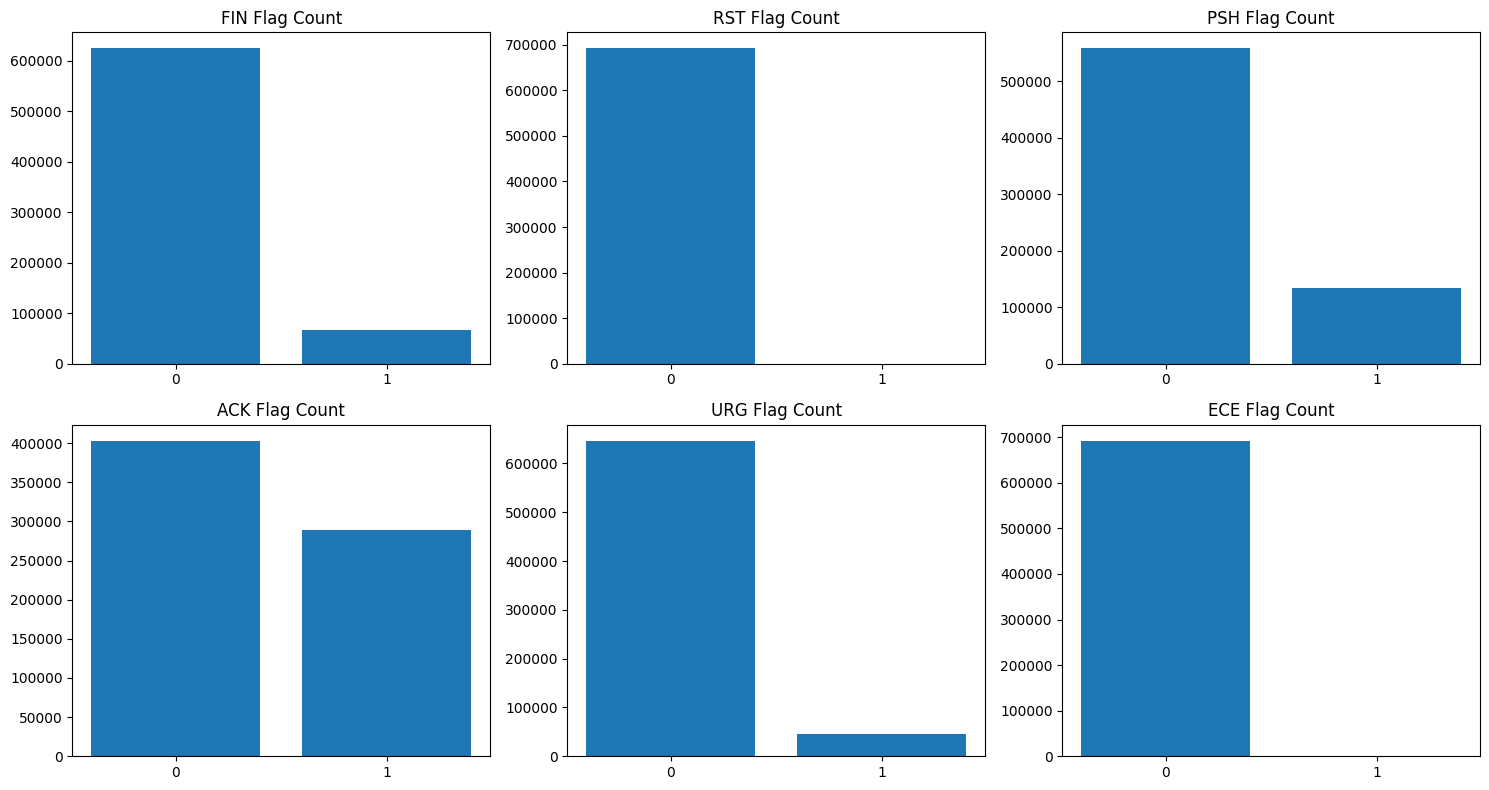

In [40]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for i in range(len(flag_columns)):
    val_count = CICIDS_data[flag_columns[i]].value_counts()
    axes[int(i/3)][i%3].bar(val_count.index, val_count.values)
    axes[int(i/3)][i%3].set_title(flag_columns[i])
    axes[int(i/3)][i%3].set_xticks([0, 1])
plt.tight_layout()
plt.show()

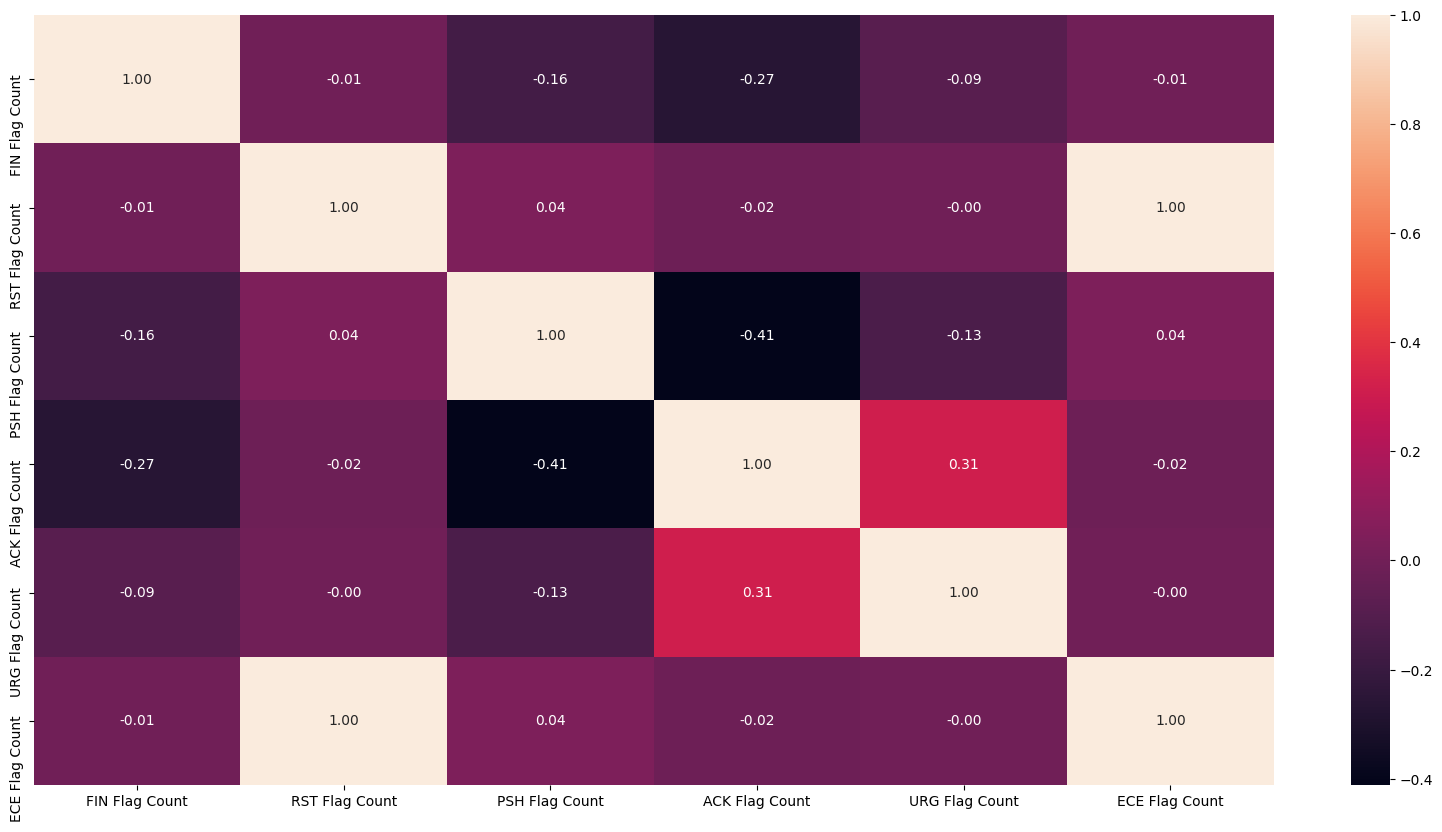

In [41]:
plt.figure(figsize=(20, 10))
corr = CICIDS_data[flag_columns].corr()
sns.heatmap(corr, annot=True, fmt=".2f")
plt.show()

### Active-Base Features 

In [42]:
active_columns = ['Active Mean', 'Active Std', 'Active Max', 'Active Min']

In [43]:
CICIDS_data[active_columns].describe()

,Active Mean,Active Std,Active Max,Active Min
count,6.927030e+05,6.927030e+05,6.927030e+05,6.927030e+05
mean,9.224478e+04,4.760852e+04,1.627363e+05,6.315186e+04
std,7.007049e+05,4.742081e+05,1.094616e+06,6.051023e+05
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,9.910000e+02,0.000000e+00,9.910000e+02,9.880000e+02
max,1.000000e+08,7.420000e+07,1.050000e+08,1.000000e+08


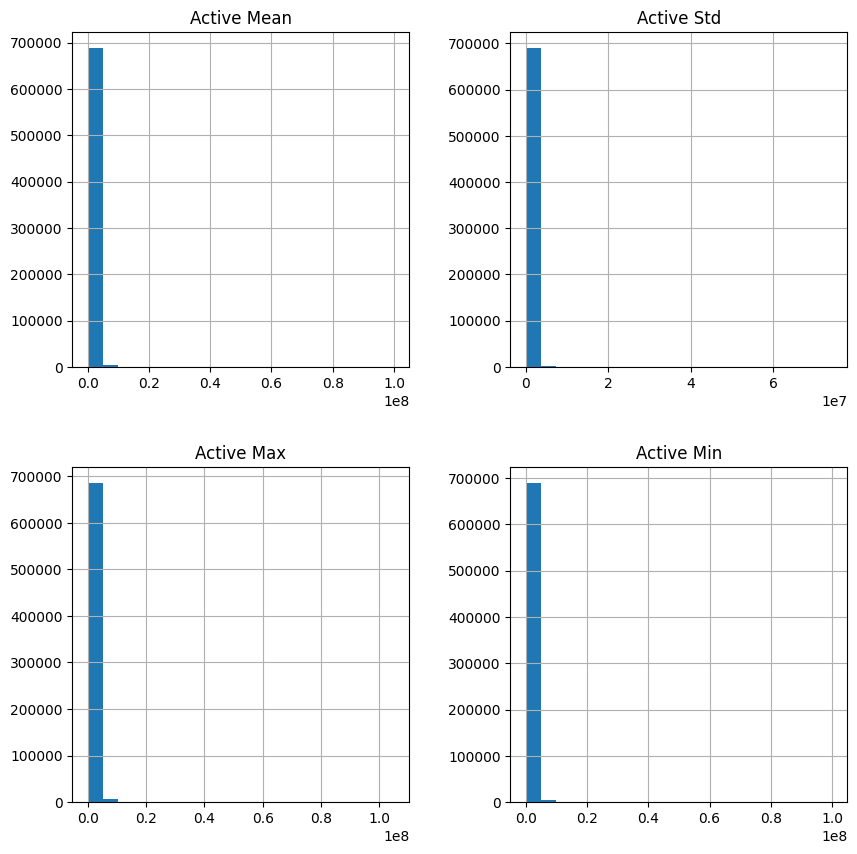

In [44]:
CICIDS_data[active_columns].hist(figsize=(10, 10), bins=20)
plt.show()

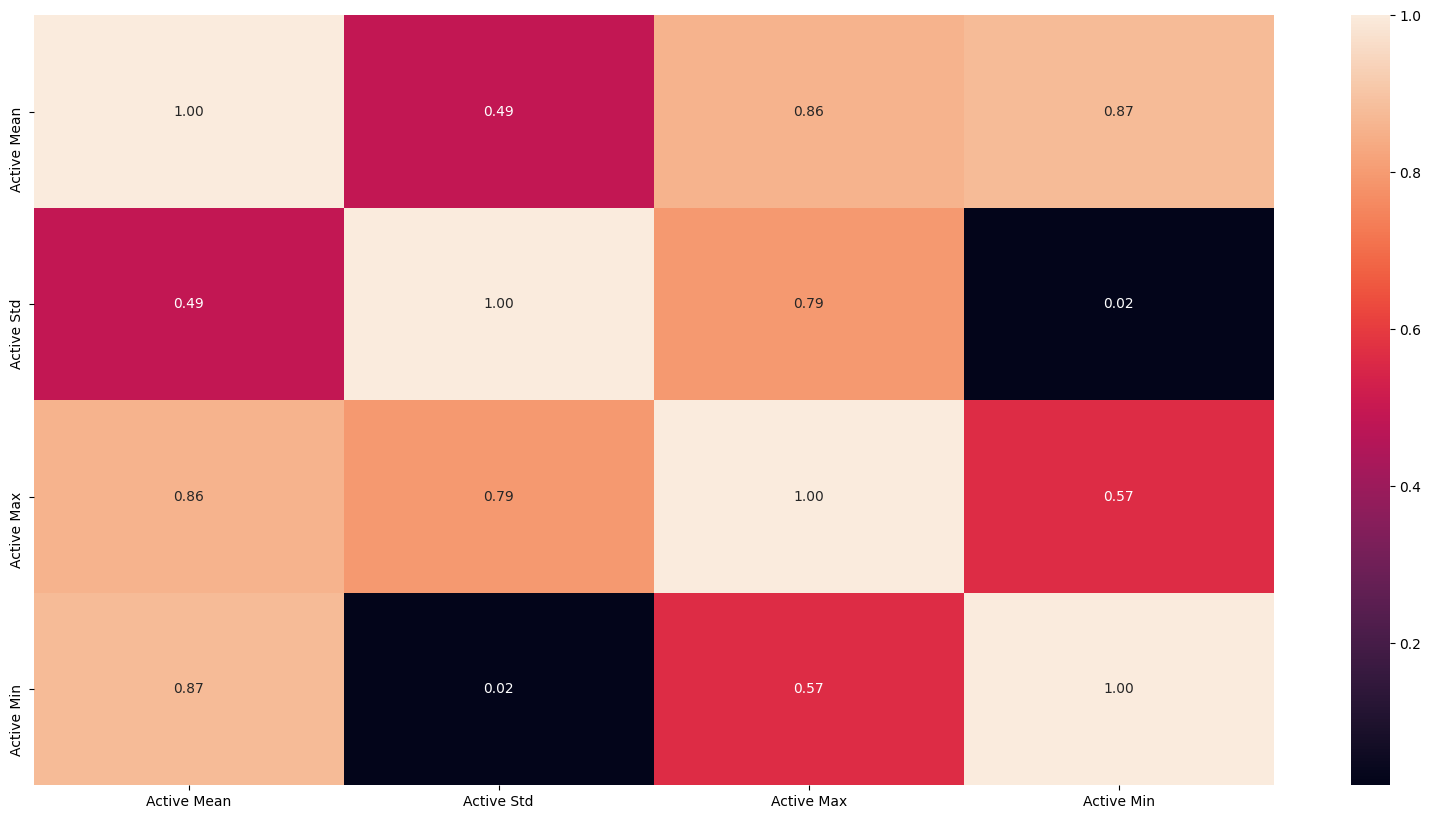

In [45]:
plt.figure(figsize=(20, 10))
corr = CICIDS_data[active_columns].corr()
sns.heatmap(corr, annot=True, fmt=".2f")
plt.show()

### Idle-Base Features

In [46]:
idle_columns = ['Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min']

In [47]:
CICIDS_data[idle_columns].describe()

,Idle Mean,Idle Std,Idle Max,Idle Min
count,6.927030e+05,6.927030e+05,6.927030e+05,6.927030e+05
mean,2.211122e+07,4.743744e+05,2.252174e+07,2.173373e+07
std,3.812415e+07,4.488512e+06,3.848292e+07,3.807725e+07
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.590000e+07,0.000000e+00,1.650000e+07,1.000000e+07
max,1.200000e+08,7.690000e+07,1.200000e+08,1.200000e+08


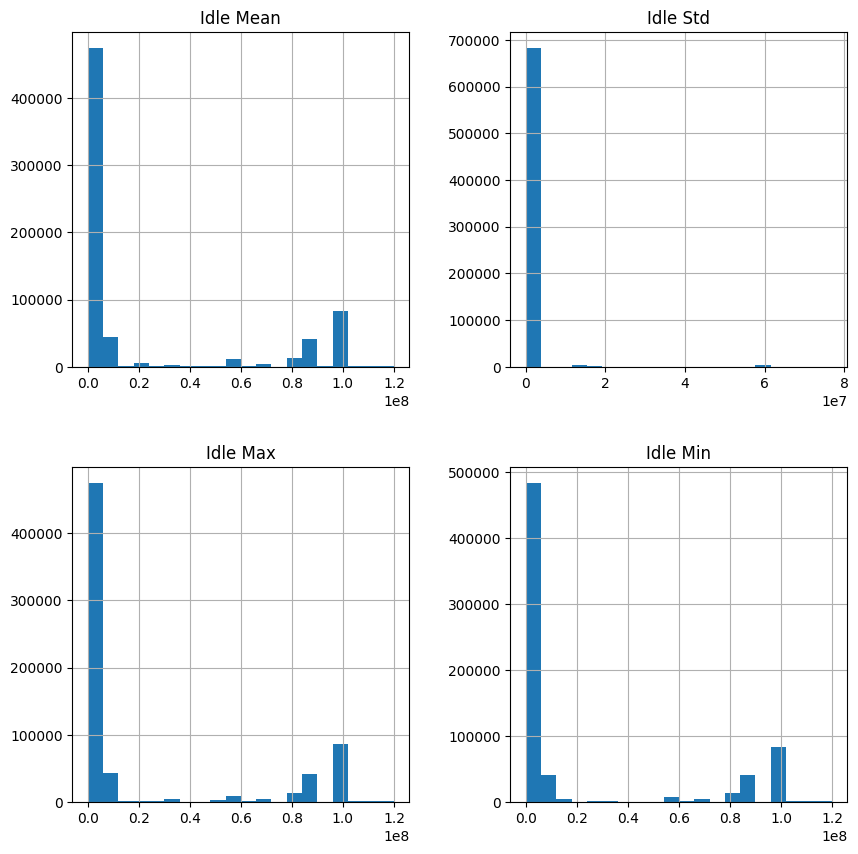

In [48]:
CICIDS_data[idle_columns].hist(figsize=(10, 10), bins=20)
plt.show()

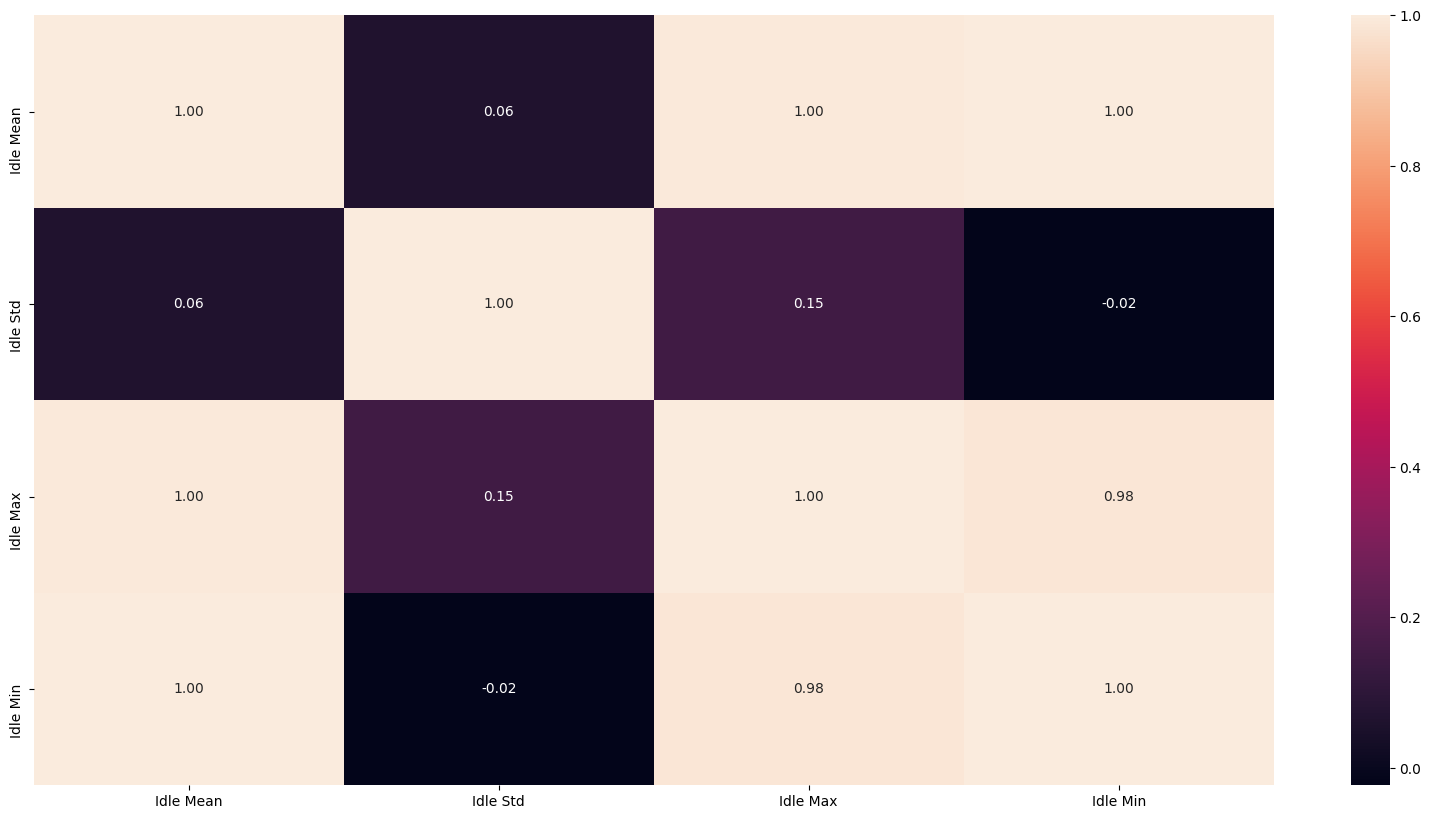

In [49]:
plt.figure(figsize=(20, 10))
corr = CICIDS_data[idle_columns].corr()
sns.heatmap(corr, annot=True, fmt=".2f")
plt.show()

### Remaining Features

In [50]:
remaining_columns = ['Down/Up Ratio', 'Average Packet Size', 'Avg Bwd Segment Size', 'Subflow Bwd Bytes', 
                     'Init_Win_bytes_forward','Init_Win_bytes_backward', 'act_data_pkt_fwd', 'min_seg_size_forward']

In [51]:
CICIDS_data[remaining_columns].describe()

,Down/Up Ratio,Average Packet Size,Avg Bwd Segment Size,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward
count,692703.000000,692703.000000,692703.000000,6.927030e+05,692703.000000,692703.000000,692703.000000,692703.000000
mean,0.556957,305.664882,551.940841,1.699489e+04,5299.671256,1476.643078,6.121279,26.761141
std,0.570734,398.045939,797.449564,2.240953e+06,11869.737394,7315.272621,715.155068,6.322368
min,0.000000,0.000000,0.000000,0.000000e+00,-1.000000,-1.000000,0.000000,-1.000000
25%,0.000000,9.000000,0.000000,0.000000e+00,-1.000000,-1.000000,0.000000,20.000000
50%,1.000000,91.000000,102.000000,1.880000e+02,251.000000,0.000000,1.000000,32.000000
75%,1.000000,696.065619,917.600000,1.159500e+04,485.500000,235.000000,2.000000,32.000000
max,43.000000,2612.000000,4370.686524,6.270464e+08,65535.000000,65535.000000,197124.000000,60.000000


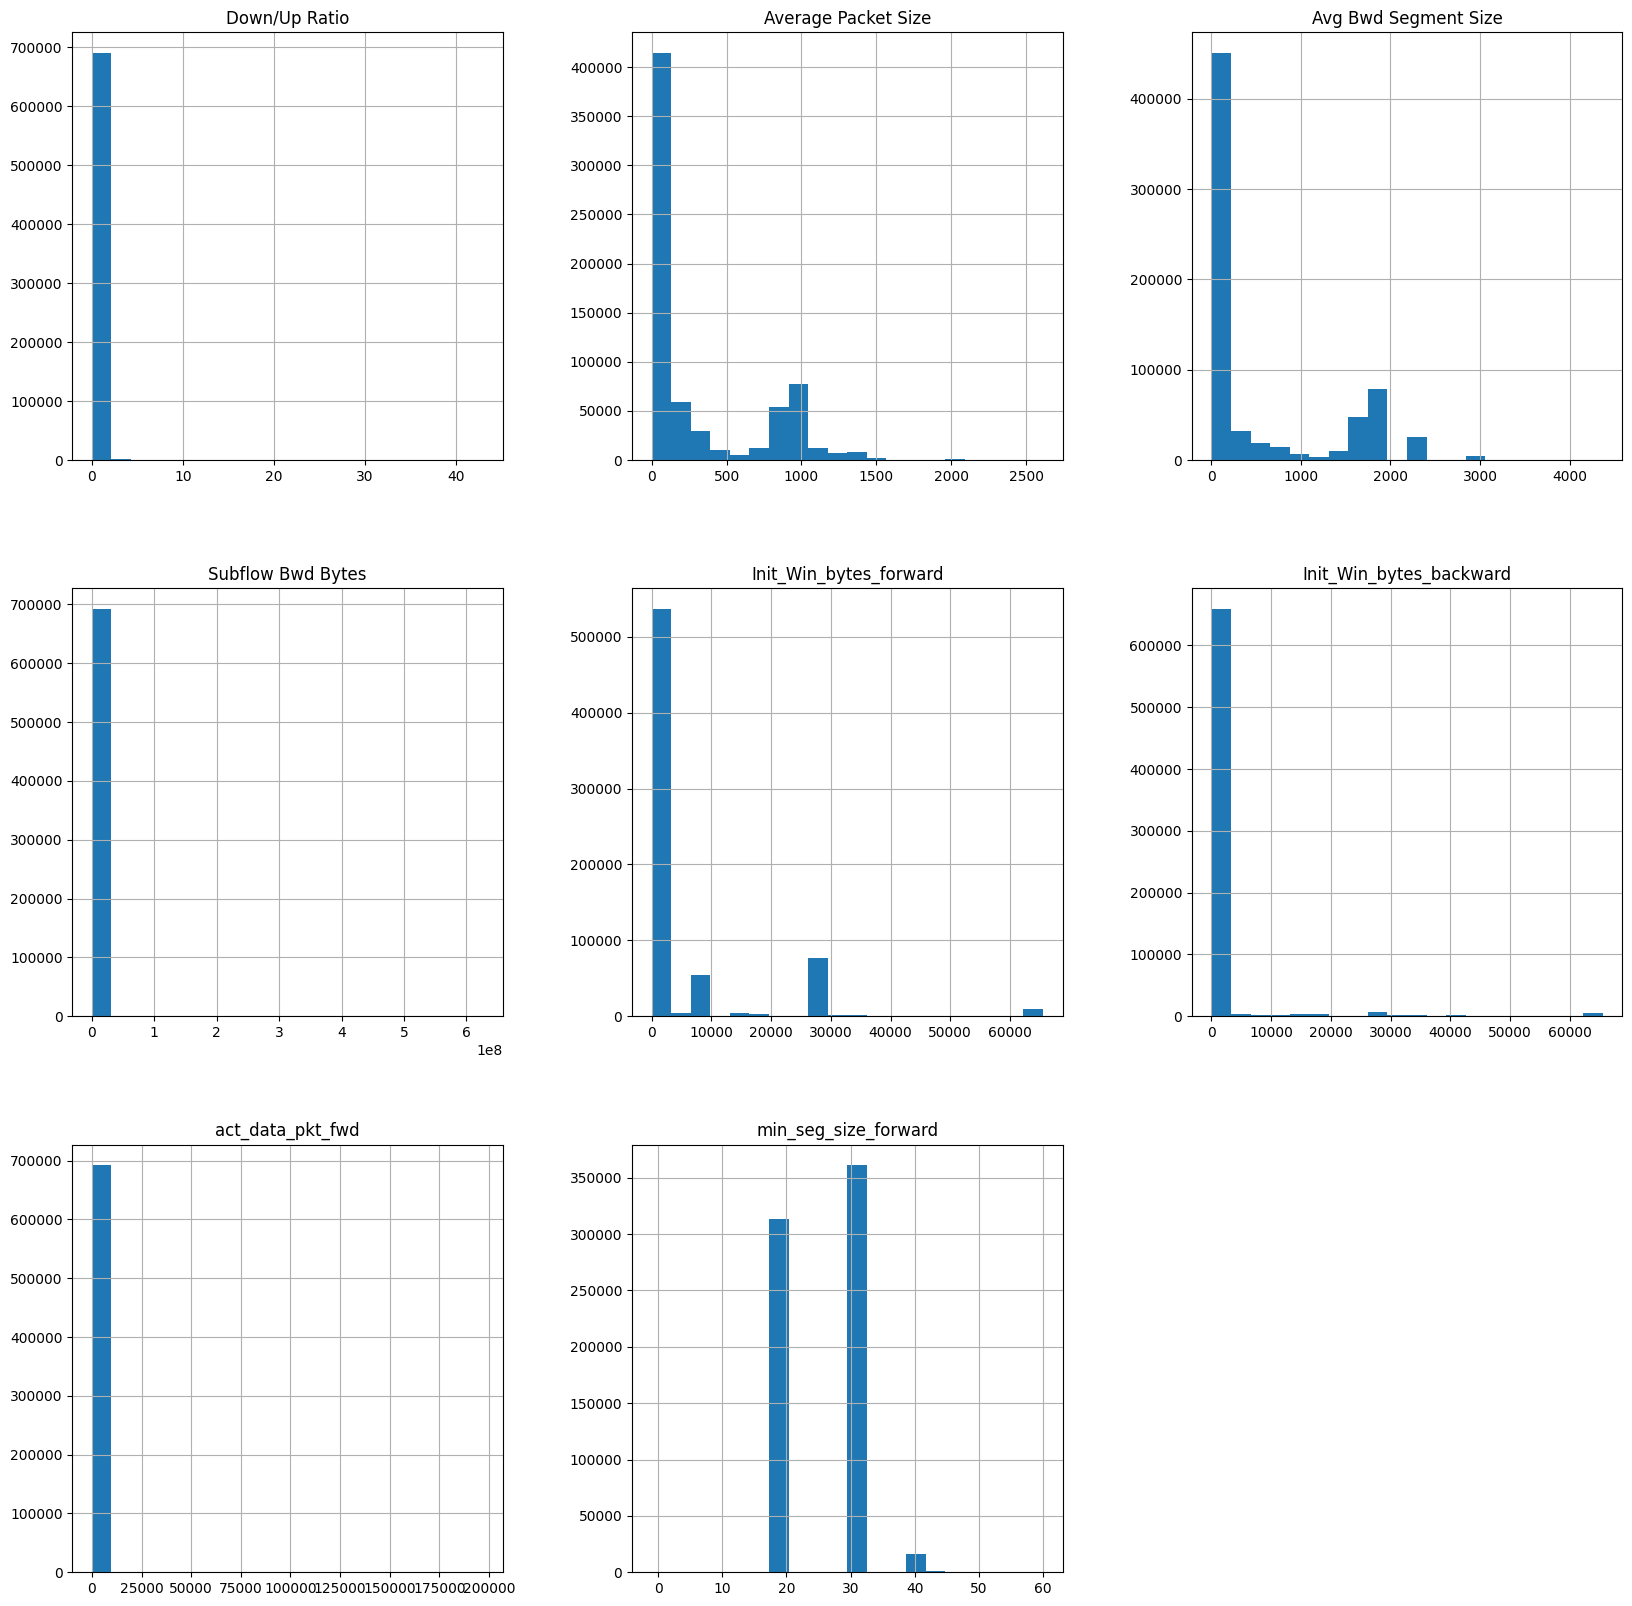

In [52]:
CICIDS_data[remaining_columns].hist(figsize=(20, 20), bins=20)
plt.show()

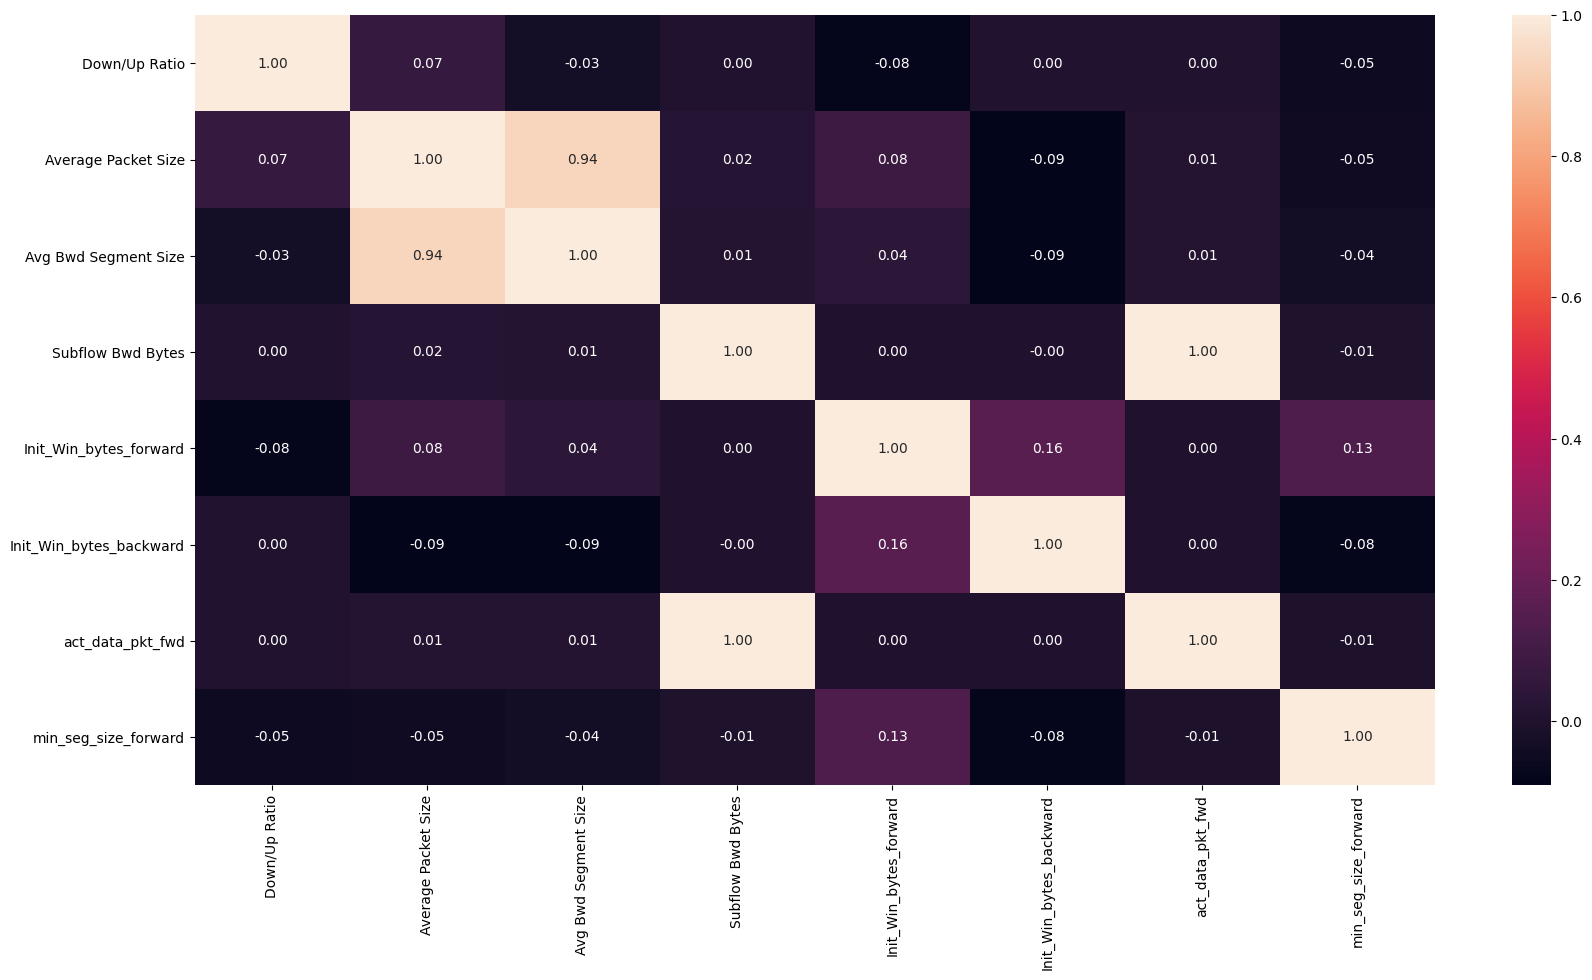

In [53]:
plt.figure(figsize=(20, 10))
corr = CICIDS_data[remaining_columns].corr()
sns.heatmap(corr, annot=True, fmt=".2f")
plt.show()

## Anomaly Detection With Isolation Forset

In [54]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter

In [55]:
CICIDS_data['Label_encoded'] = CICIDS_data['Label'].apply(lambda x:1 if x=='BENIGN' else -1)

In [56]:
X = CICIDS_data.drop(['Label','Flow Bytes/s', 'Flow Packets/s', 'Label_encoded'],axis=1).copy()
y = CICIDS_data['Label_encoded'].copy()

In [57]:
X.fillna(0, inplace=True) 

In [58]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

In [59]:
contamination = y.value_counts()[-1]/len(y)

In [60]:
contamination

0.36476238734349353

In [61]:
model = IsolationForest(contamination=contamination, random_state=42)

In [62]:
model.fit(X_scaled)
predictions = model.predict(X_scaled)

In [63]:
print("Classification Report:")
print(classification_report(y, predictions))

# Confusion Matrix
cm = confusion_matrix(y, predictions)

Classification Report:
              precision    recall  f1-score   support

          -1       0.66      0.66      0.66    252672
           1       0.81      0.81      0.81    440031

    accuracy                           0.75    692703
   macro avg       0.73      0.73      0.73    692703
weighted avg       0.75      0.75      0.75    692703



## Deep Learning Nural Netwark Multi-Label Classifier

In [64]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [102]:
X = CICIDS_data.drop(['Label','Flow Bytes/s', 'Flow Packets/s', 'Label_encoded'],axis=1).copy()
y = CICIDS_data['Label'].copy()

In [103]:
X.fillna(0, inplace=True) 

In [104]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

In [105]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

In [116]:
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

In [117]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [118]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
13855/13855 [==============================] - 11s 774us/step - loss: 472.1879 - accuracy: 0.9473 - val_loss: 0.1591 - val_accuracy: 0.9617
Epoch 2/20
13855/13855 [==============================] - 10s 756us/step - loss: 0.3543 - accuracy: 0.9062 - val_loss: 0.2317 - val_accuracy: 0.8988
Epoch 3/20
13855/13855 [==============================] - 10s 730us/step - loss: 0.2946 - accuracy: 0.9016 - val_loss: 0.2212 - val_accuracy: 0.9016
Epoch 4/20
13855/13855 [==============================] - 10s 729us/step - loss: 0.2241 - accuracy: 0.9313 - val_loss: 0.1463 - val_accuracy: 0.9653
Epoch 5/20
13855/13855 [==============================] - 10s 743us/step - loss: 0.2403 - accuracy: 0.9641 - val_loss: 0.1337 - val_accuracy: 0.9656
Epoch 6/20
13855/13855 [==============================] - 11s 808us/step - loss: 0.1849 - accuracy: 0.9657 - val_loss: 0.1471 - val_accuracy: 0.9657
Epoch 7/20
13855/13855 [==============================] - 12s 837us/step - loss: 0.1599 - accuracy: 0.96

In [119]:
y_pred = np.argmax(model.predict(X_test), axis=1)

In [120]:
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print(confusion_matrix(y_test, y_pred))

                  precision    recall  f1-score   support

          BENIGN       0.87      1.00      0.93     88170
   DoS GoldenEye       1.00      0.59      0.74      2017
        DoS Hulk       1.00      0.77      0.87     46147
DoS Slowhttptest       1.00      0.08      0.15      1090
   DoS slowloris       0.96      0.04      0.08      1114
      Heartbleed       0.00      0.00      0.00         3

        accuracy                           0.90    138541
       macro avg       0.80      0.41      0.46    138541
    weighted avg       0.91      0.90      0.89    138541

[[88025     5   139     0     1     0]
 [  826  1186     5     0     0     0]
 [10742     0 35405     0     0     0]
 [ 1002     0     0    87     1     0]
 [ 1064     0     1     0    49     0]
 [    3     0     0     0     0     0]]


/Users/traviv/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/traviv/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/traviv/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Machine Learning Xgboost Multi-Label Classifier and Feature Importancy

In [75]:
from sklearn.multioutput import MultiOutputClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MultiLabelBinarizer
from sklearn.metrics import classification_report, accuracy_score

In [76]:
X = CICIDS_data.drop(['Label','Flow Bytes/s', 'Flow Packets/s', 'Label_encoded'],axis=1).copy()
y = CICIDS_data['Label'].copy()

In [77]:
X.fillna(0, inplace=True) 

In [78]:
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

In [79]:
onehot_encoder = OneHotEncoder(sparse_output=False)
y_encoded = onehot_encoder.fit_transform(y.values.reshape(-1, 1))

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

In [91]:
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')

In [92]:
multi_target_xgb = MultiOutputClassifier(xgb_model, n_jobs=-1)

In [93]:
multi_target_xgb.fit(X_train, y_train)

MultiOutputClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='mlogloss',
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_rate=None, max_bin=None,
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...),
                      n_jobs=-1)

In [94]:
y_pred = multi_target_xgb.predict(X_test)

In [95]:
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=onehot_encoder.categories_[0]))

Classification Report:
                  precision    recall  f1-score   support

          BENIGN       1.00      1.00      1.00     88170
   DoS GoldenEye       1.00      1.00      1.00      2017
        DoS Hulk       1.00      1.00      1.00     46147
DoS Slowhttptest       1.00      0.99      0.99      1090
   DoS slowloris       0.99      0.99      0.99      1114
      Heartbleed       1.00      1.00      1.00         3

       micro avg       1.00      1.00      1.00    138541
       macro avg       1.00      1.00      1.00    138541
    weighted avg       1.00      1.00      1.00    138541
     samples avg       1.00      1.00      1.00    138541



/Users/traviv/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/traviv/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [11:22:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/traviv/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [11:22:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/traviv/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [11:22:09] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Pa

In [86]:
y_pred_decoded = onehot_encoder.categories_[0][np.argmax(y_pred, axis=1)]
y_test_decoded = onehot_encoder.categories_[0][np.argmax(y_test, axis=1)]

In [87]:
for i, label in enumerate(onehot_encoder.categories_[0]):
    accuracy = accuracy_score(y_test_decoded == label, y_pred_decoded == label)
    print(f"Accuracy for {label}: {accuracy:.2f}")

Accuracy for BENIGN: 1.00
Accuracy for DoS GoldenEye: 1.00
Accuracy for DoS Hulk: 1.00
Accuracy for DoS Slowhttptest: 1.00
Accuracy for DoS slowloris: 1.00
Accuracy for Heartbleed: 1.00


In [88]:
def get_important_features(X, model, n_features, with_score = False):
    all_features = X.columns.to_list()
    feature_importances = []
    for idx, estimator in enumerate(multi_target_xgb.estimators_):
        importances = estimator.feature_importances_
        feature_importances.append(importances)
    average_importances = np.mean(feature_importances, axis=0)
    indices_of_largest = np.argsort(average_importances)[-n_features:][::-1]
    if with_score:
        n_important_features = [(all_features[i],average_importances[i]) for i in indices_of_largest]
    else:
        n_important_features = [all_features[i] for i in indices_of_largest]
    return n_important_features

In [89]:
n_important_features = get_important_features(X, multi_target_xgb, 10, True)

In [90]:
n_important_features

[('Bwd Packet Length Std', 0.19318448),
 ('Packet Length Mean', 0.11843445),
 ('Active Std', 0.110743515),
 ('Bwd Packet Length Max', 0.07032435),
 ('Bwd IAT Std', 0.05684802),
 ('Active Min', 0.04791169),
 ('Total Backward Packets', 0.046306435),
 ('Packet Length Std', 0.039558824),
 ('Destination Port', 0.03697658),
 ('Bwd Packets/s', 0.029356735)]

/Users/traviv/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [11:01:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/traviv/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [11:01:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/traviv/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [11:01:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/traviv/opt/anaconda3/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [11:01:32] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserW